# Data gemeenteraadsverkiezingen 2022 Nederland

Dit notebook is voor het verwerken van de data van de gemeenteraadsverkiezingen van 2022. Er zal hier stap voor stap door de data gelopen worden om het proces reproduceerbaar te maken voor latere verkiezingen. De eerste stap was de data ophalen van de bronnen, zowel de overheid als waar is mijn stemlokaal (voor geografische data van de stemlokalen). De bronnen gebruikt voor de data zijn voor de verkiezingen van 2022 is als volgt:

- [Verkiezingsuitslagen Gemeenteraad 2022](https://data.overheid.nl/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43)
  - [Directe link naar uitslagen per gemeente CSV](https://data.overheid.nl/sites/default/files/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43/resources/GR2022_2022-03-29T15.14.zip)
  - [Directe link naar kandidatenlijst met uitslagen CSV](https://data.overheid.nl/sites/default/files/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43/resources/GR2022_alle-kandidaten_2022-02-22T08.34.csv)
- [Waar is mijn stemlokaal stembureau data](https://waarismijnstemlokaal.nl/data)
  - [Directe link naar waar is mijn stemlokaal gemeenteraad 2022 CSV (CKAN)](https://ckan.dataplatform.nl/datastore/dump/d6a1b4c4-73c8-457b-9b75-a38428bded68)
  - [Verkiezingsuitslagen gemeenteraadsverkiezingen 2022 geodata (Volkskrant)](https://data.openstate.eu/dataset/verkiezingsuitslagen-gemeenteraadsverkiezingen-2022)
    - [Directe link naar GEOJSON bestand](https://data.openstate.eu/dataset/a1767f1b-bf0c-409b-b3b1-3af9954b57f4/resource/413be255-5070-48f4-b631-895097976abb/download/2022gr.geo.json)
- [CBS Wijk- en buurtkaart 2021](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2021)
  - [Directe link naar zip bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/wijkbuurtkaart_2021_v1.zip)
- [CBS bevolkingsdichtheid kaart 100 bij 100 meter](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/kaart-van-100-meter-bij-100-meter-met-statistieken)
  - [Directe link naar 7z bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/vierkanten/100/nl_vierkant_100meter_bij_100meter.7z)
- [CBS bevolkingsdichtheid kaart 500 bij 500 meter](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/kaart-van-500-meter-bij-500-meter-met-statistieken)
  - [Directe link naar 7z bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/vierkanten/500/2021-cbs_vk500_2020_v1.zip)
- [CBS schatting van kiesgerechtigden per gemeente](https://www.cbs.nl/nl-nl/maatwerk/2020/52/schatting-van-het-aantal-kiesgerechtigden-in-nederland)

De eerste stap die we moeten maken is de data importeren voor de analyse, daarna kunnen we kijken hoe goed de data is, hoe we het aan kunnen vullen, en wat er mee te doen. De makkelijkste structuur die we vonden was het geojson bestand van open state en de Volkskrant, daar staan alle stemlokalen al in een lijst, en we hebben een makkelijk framework om het te importeren; geopandas. We laden deze dan ook als eerste in.

In [2]:
import pandas as pd
import geopandas as gpd

crs = {'init':'EPSG:4326'}
df_geojson = gpd.read_file(r'../data/2022gr.geo.json', crs=crs)

/home/lillian/.local/lib/python3.9/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 61
  self._schema = self.session.get_schema()
/home/lillian/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:600: UserWarning: Empty field name at index 61
  for feature in features_lst:


We importeren nu de gemeente shapefile kaart van het CBS, om de overlay van onze stemlokalen eroverheen te kunnen doen. 

<AxesSubplot:>

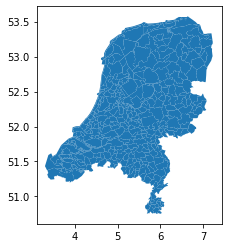

In [3]:
nl_map = gpd.read_file(r'../data/shape/Netherlands_shapefile/gemeente_2021_v1.shp')
nl_map.to_crs(epsg=4326).plot()


In [4]:
print(nl_map)

    GM_CODE            GM_NAAM  H2O       OAD      STED  BEV_DICHTH  AANT_INW  \
0    GM0034             Almere   JA -99999999 -99999999   -99999999 -99999999   
1    GM0050           Zeewolde   JA -99999999 -99999999   -99999999 -99999999   
2    GM0060            Ameland   JA -99999999 -99999999   -99999999 -99999999   
3    GM0072          Harlingen   JA -99999999 -99999999   -99999999 -99999999   
4    GM0088    Schiermonnikoog   JA -99999999 -99999999   -99999999 -99999999   
..      ...                ...  ...       ...       ...         ...       ...   
430  GM1966       Het Hogeland  NEE       414         5          99     47834   
431  GM1969     Westerkwartier  NEE       476         5         176     63678   
432  GM1970  Noardeast-Fryslân  NEE       463         5         120     45481   
433  GM1978        Molenlanden  NEE       393         5         243     44130   
434  GM1979          Eemsdelta  NEE       692         4         170     45587   

     AANT_MAN  AANT_VROUW  

<AxesSubplot:>

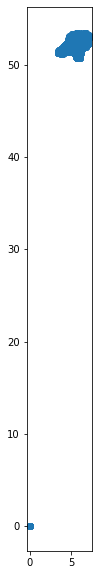

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson.plot(ax=ax)

We hebben hier een probleem dat sommige punten de coördinaten 0,0 hebben, dit is niet iets wat we willen weergeven. Laten we eerst kijken waarom dit het geval is in de data voordat we het er helemaal uithalen.

In [6]:
for index, row in df_geojson.iterrows():
    if (row.geometry.centroid.x == 0.00000):
        print(row)

Stembureau                                                            32
Adres                                                                   
Locatie                                                             SB32
description                               Stembureau Mobiel Stembureau 1
Geldige stemmen                                                       99
                                                       ...              
"Leefbaar 's-Hertogenbosch" Paul Kagie                               NaN
RAADSGROEPERING ''BOSCH-BELANG''                                     NaN
gewoon ge-DREVEN                                                     NaN
VOOR Den Bosch Joep Gersjes                                          NaN
geometry                                                     POINT (0 0)
Name: 2520, Length: 973, dtype: object
Stembureau                                                            33
Adres                                                                   
Locatie     

Het zijn dus duidelijk allemaal mobiele stemlokalen, die kunnen we in een aparte dataset houden voor later, voor nu zijn ze onbelangrijk voor de kaartweergave, laten we de dataset dus opsplitsen in drie dataframes, de originele, één frame zonder de mobiele stemlokalen, en de mobiele stemlokalen alleen.

In [7]:
#de waarschuwing over de projectie die niet klopt kan genegeerd worden, we zoeken naar data die x = 0 is, de projectie gaat geen effect hebben op die data in Nederland
#filter de data en print welke waardes 0 hebben op x
mobiel_mask = df_geojson['geometry'].centroid.x == 0
i = 0
for item in mobiel_mask:
    if item:
        print(i)
    i = i + 1

/tmp/ipykernel_7786/291552514.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mobiel_mask = df_geojson['geometry'].centroid.x == 0


2520
2521
2918
3579
3580
3581
3582
3583
5494
5784
5785
6260
6261
6738
6739
6863
7348
7364
7857
7912
7913
7923
7924
7926
7958
7959
7960
8108
8109
8161
8162
8163
8318
9093
9151
9152
9153
9661
9853
10427
10431
10497
10498
10525
10526
10527
10528
10623
10624
10894
10895
11032
11101
12038
12039
12053
12054
12118
12119
12120
12121
12504
12505
12506


In [8]:
df_geojson_clean = df_geojson[~mobiel_mask]
df_geojson_mobiel = df_geojson[mobiel_mask]
print(df_geojson_clean)

       Stembureau   Adres Locatie  \
0               1  9461BH     SB1   
1               2  9461DA     SB2   
2               3  9461JA     SB3   
3               4  9451KD     SB4   
4               6  9454PL     SB6   
...           ...     ...     ...   
12591         703  5391AR   SB703   
12592         705  5391AR   SB705   
12593         750  5382KE   SB750   
12594         751  5382KE   SB751   
12595         752  5283KE   SB752   

                                             description  Geldige stemmen  \
0      Stembureau Gemeentehuis Gieten (postcode: 9461...              784   
1              Stembureau OBS Gieten (postcode: 9461 DA)              562   
2      Stembureau Zorgcentrum Dekelhem (postcode: 946...              566   
3      Stembureau Ontmoetingscentrum Boerhorn Rolde (...             1495   
4      Stembureau Dropshuis de Eekhof (postcode: 9454...              347   
...                                                  ...              ...   
12591  Stemburea

In [9]:
#let's also check if none fell through the cracks, it might be some mobile polls did actually have a location posted erroneously.
#mobiel_mask_name = df_geojson_clean['description'].str.contains('Mobiel')
#df_geojson_clean = df_geojson_clean[~mobiel_mask_name]
#df_geojson_clean

In [10]:
df_wims = pd.read_csv(r'../data/wims-2.csv')
df_wims

,_id,Gemeente,CBS gemeentecode,Nummer stembureau,Naam stembureau,Gebruiksdoel van het gebouw,Website locatie,Wijknaam,CBS wijknummer,Buurtnaam,...,Visuele hulpmiddelen,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID
0,1,Valkenswaard,GM0858,1,Zorgcentrum Kempenhof,gezondheidszorgfunctie,https://www.valkenhof.nl/,NaN,NaN,NaN,...,leesloep,ja,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,3a612b2151fa4ab491b9e331355e6258
1,2,Valkenswaard,GM0858,2,Buurtgebouw De Horizon,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,leesloep,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,9a01d765af0a467ea37f08d92db114ba
2,3,Valkenswaard,GM0858,3,Speeltuin Geenhoven,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,leesloep,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,fc5869d33fbc4b06be659149fa615f4c
3,4,Valkenswaard,GM0858,4,Ontmoetingscentrum De zoete inval,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,leesloep,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,4427cc0b39e040ba8f75c333f19d66f0
4,5,Valkenswaard,GM0858,5,Gymnastiekzaal 't Gegraaf,sportfunctie,NaN,NaN,NaN,NaN,...,leesloep,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,a893bb9add324ce29769f1c39afcc48d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9270,38745,Gennep,GM0907,4,Het Hökske,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,Leesloep,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,f744546cd6894e5e9a4db4bbfd81b4ee
9271,38746,Gennep,GM0907,5,Buurthuis VanOns,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,Leesloep,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,1270081b1dc74cd7bea0f45973650408
9272,38747,Gennep,GM0907,6,'t Trefpunt,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,Leesloep,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,447c7742604345139e41def4cf1e4d3c
9273,38748,Gennep,GM0907,8,De Uitkomst,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,Leesloep,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,049cfd258c174bc49abf17883396d083


In [11]:

gdf_wims = gpd.GeoDataFrame(
    df_wims, geometry=gpd.points_from_xy(df_wims.Longitude, df_wims.Latitude)).set_crs(epsg=4326, inplace=True)

gdf_wims

,_id,Gemeente,CBS gemeentecode,Nummer stembureau,Naam stembureau,Gebruiksdoel van het gebouw,Website locatie,Wijknaam,CBS wijknummer,Buurtnaam,...,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID,geometry
0,1,Valkenswaard,GM0858,1,Zorgcentrum Kempenhof,gezondheidszorgfunctie,https://www.valkenhof.nl/,NaN,NaN,NaN,...,ja,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,3a612b2151fa4ab491b9e331355e6258,POINT (5.45515 51.34711)
1,2,Valkenswaard,GM0858,2,Buurtgebouw De Horizon,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,9a01d765af0a467ea37f08d92db114ba,POINT (5.45137 51.34955)
2,3,Valkenswaard,GM0858,3,Speeltuin Geenhoven,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,fc5869d33fbc4b06be659149fa615f4c,POINT (5.44827 51.35702)
3,4,Valkenswaard,GM0858,4,Ontmoetingscentrum De zoete inval,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,4427cc0b39e040ba8f75c333f19d66f0,POINT (5.44871 51.36022)
4,5,Valkenswaard,GM0858,5,Gymnastiekzaal 't Gegraaf,sportfunctie,NaN,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,a893bb9add324ce29769f1c39afcc48d,POINT (5.45331 51.36514)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9270,38745,Gennep,GM0907,4,Het Hökske,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,f744546cd6894e5e9a4db4bbfd81b4ee,POINT (5.98266 51.69726)
9271,38746,Gennep,GM0907,5,Buurthuis VanOns,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,1270081b1dc74cd7bea0f45973650408,POINT (5.98127 51.69000)
9272,38747,Gennep,GM0907,6,'t Trefpunt,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,447c7742604345139e41def4cf1e4d3c,POINT (5.95118 51.72591)
9273,38748,Gennep,GM0907,8,De Uitkomst,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,049cfd258c174bc49abf17883396d083,POINT (6.01556 51.70976)


In [12]:
gdf_wims_dedupe = gdf_wims.drop_duplicates(subset ="geometry", keep = False)
df_geojson_dedupe = df_geojson_clean.drop_duplicates(subset ="geometry", keep = False)
gdf_wims_dedupe

,_id,Gemeente,CBS gemeentecode,Nummer stembureau,Naam stembureau,Gebruiksdoel van het gebouw,Website locatie,Wijknaam,CBS wijknummer,Buurtnaam,...,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID,geometry
0,1,Valkenswaard,GM0858,1,Zorgcentrum Kempenhof,gezondheidszorgfunctie,https://www.valkenhof.nl/,NaN,NaN,NaN,...,ja,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,3a612b2151fa4ab491b9e331355e6258,POINT (5.45515 51.34711)
1,2,Valkenswaard,GM0858,2,Buurtgebouw De Horizon,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,9a01d765af0a467ea37f08d92db114ba,POINT (5.45137 51.34955)
2,3,Valkenswaard,GM0858,3,Speeltuin Geenhoven,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,fc5869d33fbc4b06be659149fa615f4c,POINT (5.44827 51.35702)
3,4,Valkenswaard,GM0858,4,Ontmoetingscentrum De zoete inval,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,4427cc0b39e040ba8f75c333f19d66f0,POINT (5.44871 51.36022)
4,5,Valkenswaard,GM0858,5,Gymnastiekzaal 't Gegraaf,sportfunctie,NaN,NaN,NaN,NaN,...,NaN,Valkenswaard,Valkenswaard,NaN,verkiezingen@valkenswaard.nl,http://www.valkenswaard.nl/verkiezingen,NaN,NLODSGM0858stembureaus20220316009,a893bb9add324ce29769f1c39afcc48d,POINT (5.45331 51.36514)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9270,38745,Gennep,GM0907,4,Het Hökske,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,f744546cd6894e5e9a4db4bbfd81b4ee,POINT (5.98266 51.69726)
9271,38746,Gennep,GM0907,5,Buurthuis VanOns,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,1270081b1dc74cd7bea0f45973650408,POINT (5.98127 51.69000)
9272,38747,Gennep,GM0907,6,'t Trefpunt,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,447c7742604345139e41def4cf1e4d3c,POINT (5.95118 51.72591)
9273,38748,Gennep,GM0907,8,De Uitkomst,bijeenkomstfunctie,NaN,NaN,NaN,NaN,...,NaN,Gennep,Gennep,ja,Klantcontactcentrum gemeente Gennep gemeente@g...,https://www.gennep.nl,NaN,NLODSGM0907stembureaus20220316009,049cfd258c174bc49abf17883396d083,POINT (6.01556 51.70976)


<AxesSubplot:>

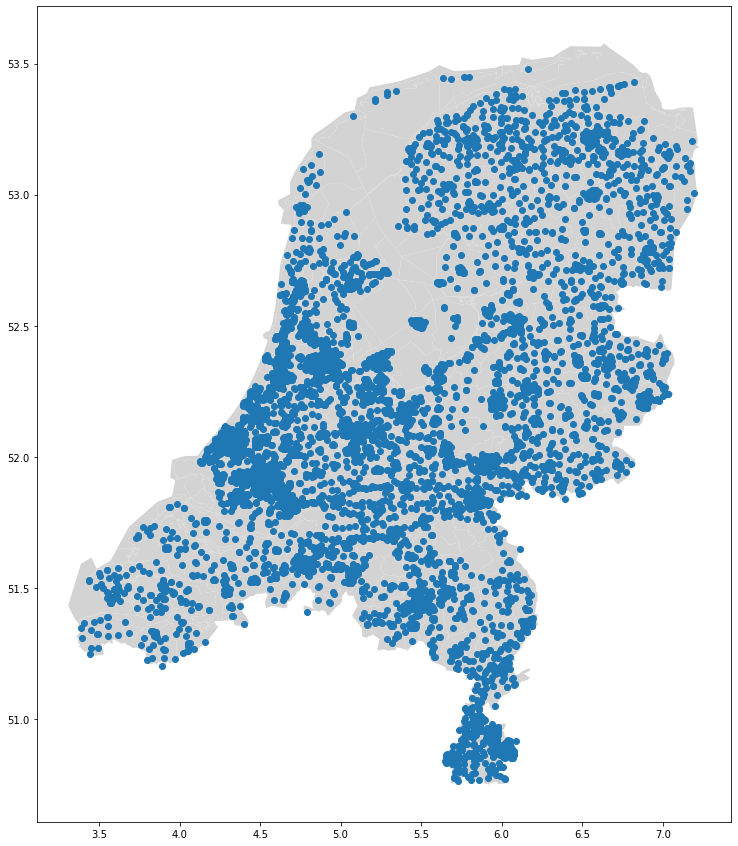

In [13]:
fig, ax = plt.subplots(figsize = (15,15))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
gdf_wims_dedupe.plot(ax=ax)

<AxesSubplot:>

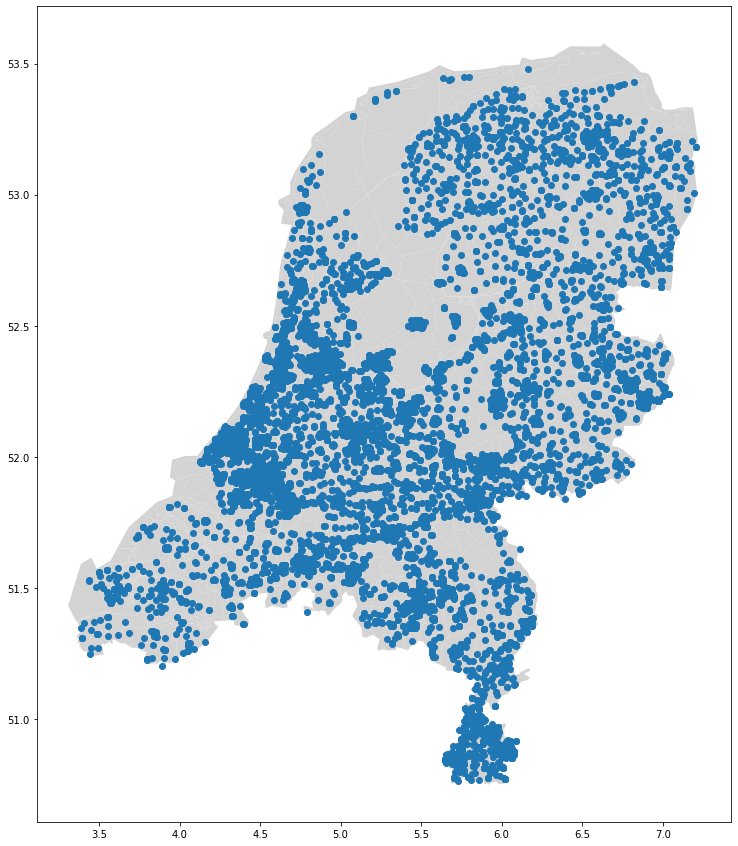

In [14]:
fig, ax = plt.subplots(figsize = (15,15))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson_clean.plot(ax=ax)

Nu we een mooie kaart hebben van nederland met de stemlokalen erop, kunnen we gaan kijken naar hoe dit verhoud met de bevolkingsdichtheid als eerste voorbeeld. De kaart is opgehaald van het CBS, eerst gaan we kijken hoe de kaart er op zichzelf met dezelfde projectie uitziet.

<AxesSubplot:>

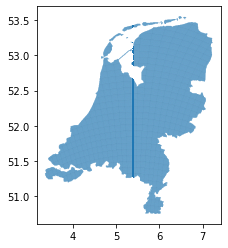

In [15]:
nl_map_cbs = gpd.read_file(r'../data/shape/Netherlands_shapefile/CBS_vk500_2020_v1.shp')
nl_map_cbs.to_crs(epsg=4326).plot()

Het verwerken van de 100m bij 100m vierkanten kaar duurde heel lang (langer dan een half uur) op de laptop, en is dus niet ideaal tenzij we dit niveau van detail écht nodig hebben. Er is namelijk nog een andere kaart met dezelfde gegevens beschikbaar, maar met een grid van 500 bij 500 meter in plaats van 100 bij 100. Laten we dus kijken hoe vaak een stemlokaal dichterbij dan 100 meter van de dichtstbijzijnde andere is. De makkelijkste manier om dat te doen zonder alle punten met alle andere te vergelijken (heel veel moeite), is een extra dataframe maken als een kopie, alle indexen 1 opschuiven (want alle stemlokalen zijn al in een volgorde van clustering), en dan de laagste afstand bekijken.

In [16]:
df_shifted = df_geojson_clean.to_crs('EPSG:28992')

df_shifted['geometry (shifted)'] = df_shifted['geometry'].shift(periods=1)
df_shifted['distance'] = df_shifted['geometry'].distance(df_shifted['geometry (shifted)'])
df_shifted.sort_values(['distance'], inplace=True, ascending=True)
zero_mask_booth = df_shifted['distance'] == 0.000000
df_shifted = df_shifted[~zero_mask_booth]
print(df_shifted['distance'])

11165         0.002608
1021          0.004853
3196          0.004875
1923          2.693202
3757          3.609362
             ...      
7444     253385.654588
9711     263408.187856
4392     266925.200994
9297     271954.076837
0                  NaN
Name: distance, Length: 11670, dtype: float64


We kunnen dus vaststellen dat afstanden van onder de 500 meter waarschijnlijk zeldzaam zijn, en we verder kunnen gaan met de 500 meter bij 500 meter kaart. Laten we nu dus een projectie proberen te maken met de bevolkingsdichtheid erop om het te vergelijken met de stemlokalen en hun posities en clustering.

In [17]:
print(list(nl_map_cbs))
nl_map_dst = nl_map_cbs.drop(columns=['MAN', 'VROUW', 'INW_014', 'INW_1524', 'INW_2544', 'INW_4564', 'INW_65PL', 'P_NL_ACHTG', 'P_WE_MIG_A', 'P_NW_MIG_A', 'AANTAL_HH', 'TOTHH_EENP', 'TOTHH_MPZK', 'HH_EENOUD', 'HH_TWEEOUD', 'GEM_HH_GR', 'WONING', 'WONVOOR45', 'WON_4564', 'WON_6574', 'WON_7584', 'WON_8594', 'WON_9504', 'WON_0514', 'WON_1524', 'WON_MRGEZ', 'P_KOOPWON', 'P_HUURWON', 'WON_HCORP', 'WON_NBEW', 'WOZWONING', 'UITKMINAOW', 'OAD', 'STED'])

nl_map_dst

['c28992r500', 'INWONER', 'MAN', 'VROUW', 'INW_014', 'INW_1524', 'INW_2544', 'INW_4564', 'INW_65PL', 'P_NL_ACHTG', 'P_WE_MIG_A', 'P_NW_MIG_A', 'AANTAL_HH', 'TOTHH_EENP', 'TOTHH_MPZK', 'HH_EENOUD', 'HH_TWEEOUD', 'GEM_HH_GR', 'WONING', 'WONVOOR45', 'WON_4564', 'WON_6574', 'WON_7584', 'WON_8594', 'WON_9504', 'WON_0514', 'WON_1524', 'WON_MRGEZ', 'P_KOOPWON', 'P_HUURWON', 'WON_HCORP', 'WON_NBEW', 'WOZWONING', 'UITKMINAOW', 'OAD', 'STED', 'geometry']


,c28992r500,INWONER,geometry
0,E2260N6190,-99997,"POLYGON ((226000.000 619000.000, 226000.000 61..."
1,E2265N6190,-99997,"POLYGON ((226500.000 619500.000, 227000.000 61..."
2,E2270N6190,-99997,"POLYGON ((227000.000 619500.000, 227500.000 61..."
3,E2275N6190,-99997,"POLYGON ((227500.000 619500.000, 228000.000 61..."
4,E2280N6190,-99997,"POLYGON ((228000.000 619500.000, 228500.000 61..."
...,...,...,...
151103,E1995N3070,-99997,"POLYGON ((199500.000 307500.000, 200000.000 30..."
151104,E1905N3065,-99997,"POLYGON ((190500.000 307000.000, 191000.000 30..."
151105,E1910N3065,-99997,"POLYGON ((191000.000 307000.000, 191500.000 30..."
151106,E1920N3065,20,"POLYGON ((192000.000 307000.000, 192500.000 30..."


We kunnen zien dat er gemeente zijn die geen stemlokalen hebben, dit klopt. [In de verkiezingen van 2022 hebben 12 gemeentes niet meegedaan](https://nl.wikipedia.org/wiki/Nederlandse_gemeenteraadsverkiezingen_2022). Er zijn dus in totaal 333 gemeentes met stemlokalen. We willen de bevolkingsdichtheiddata van de gemeentes die niet meededen dus weggooien, hiervoor moeten we eerst kijken welke alleen binnen de gemeentes vallen die we niet willen houden.

In [18]:
print(df_geojson['electionName'])

#get all municipalities that are in the election
gemeentes = df_geojson['electionName'].str.slice(13, -5).drop_duplicates()
print(gemeentes)

0             Gemeenteraad Aa en Hunze 2022
1             Gemeenteraad Aa en Hunze 2022
2             Gemeenteraad Aa en Hunze 2022
3             Gemeenteraad Aa en Hunze 2022
4             Gemeenteraad Aa en Hunze 2022
                        ...                
12591    Gemeenteraad 's-Hertogenbosch 2022
12592    Gemeenteraad 's-Hertogenbosch 2022
12593    Gemeenteraad 's-Hertogenbosch 2022
12594    Gemeenteraad 's-Hertogenbosch 2022
12595    Gemeenteraad 's-Hertogenbosch 2022
Name: electionName, Length: 12596, dtype: object
0             Aa en Hunze
27               Aalsmeer
46                 Aalten
74          Achtkarspelen
95           Alblasserdam
               ...       
11976     Zwartewaterland
11997         Zwijndrecht
12031              Zwolle
12122       's-Gravenhage
12495    's-Hertogenbosch
Name: electionName, Length: 333, dtype: object


In [19]:
#First let's remove the municipalities that don't have an Election from the municipality map
remove_lst = ["Boxtel", "Eemsdelta", "Oisterwijk", "Vught", "Heerhugowaard", "Langedijk", "Boxmeer", "Cuijk", "Sint Anthonis", "Mill en Sint Hubert", "Grave", "Landerd", "Uden", "Brielle", "Hellevoetsluis", "Westvoorne", "Purmerend", "Beemster", "Weesp"]


nl_map_clean = nl_map[~nl_map["GM_NAAM"].isin(remove_lst)]
nl_map_clean = nl_map_clean.query("H2O != 'JA'")
nl_map_clean = nl_map_clean.query("GM_NAAM != 'Buitenland'")


nl_map_election = nl_map[nl_map["GM_NAAM"].isin(gemeentes)]
nl_map_election = nl_map_election.query("H2O != 'JA'")

print("Shape of clean: {}".format(nl_map_clean.shape))
print("Shape of election: {}".format(nl_map_election.shape))

diff = pd.concat([nl_map_election, nl_map_clean]).drop_duplicates(keep=False)
diff

Shape of clean: (333, 38)
Shape of election: (330, 38)


,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,...,P_TURKIJE,P_OVER_NW,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry
113,GM0164,Hengelo,NEE,1845,2,1332,81049,40776,40273,15,...,6,7,6183,6084,99,2021GM0164,2021,47510.255914,6.183056e+07,"POLYGON ((251978.591 481220.258, 251979.382 48..."
191,GM0373,Bergen (NH.),NEE,819,4,300,29715,14317,15398,12,...,0,3,12023,9896,2127,2021GM0373,2021,57488.474563,9.987418e+07,"POLYGON ((105976.650 529056.951, 106002.347 52..."
328,GM0893,Bergen (L.),NEE,318,5,127,13108,6568,6540,13,...,0,3,10850,10324,525,2021GM0893,2021,61497.563571,1.084951e+08,"POLYGON ((199768.270 409749.960, 199758.060 40..."


Het is een andere vorm omdat deze drie gemeentes een andere format hadden voor de naam van hun verkiezingen, en dus niet op dezelfde manier gefilterd konden worden, ze staan wel in de lijst, dit is dus correct, we gebruiken de clean dataframe.
Nu we dezelfde lijst hebben van gemeentes die in de verkiezingen meededen kunnen we verder.

<AxesSubplot:>

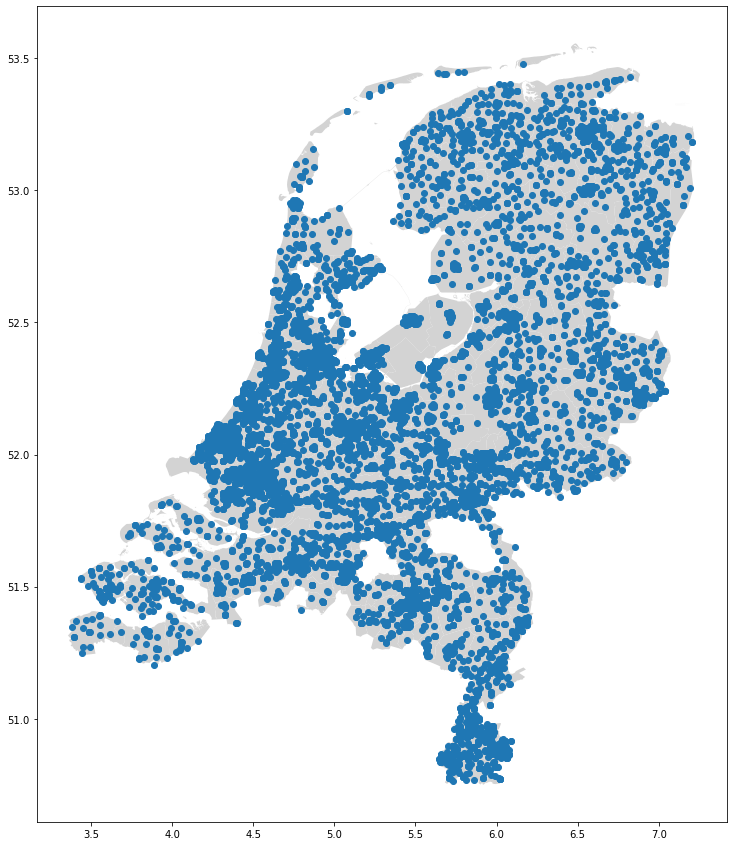

In [20]:
fig, ax = plt.subplots(figsize = (15,15))
nl_map_clean.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson_clean.plot(ax=ax)

<AxesSubplot:>

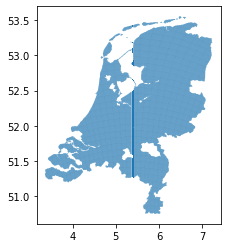

In [21]:
nl_map_dst['savedindex'] = nl_map_dst.index #Save the index values as a new column

intersecting = nl_map_clean.sjoin(nl_map_dst, how='inner')['savedindex'] #Find the polygons that intersect. Keep savedindex as a series

nl_map_dst = nl_map_dst.loc[nl_map_dst.savedindex.isin(intersecting)] #Filter away these, "savedindex is in intersecting"

nl_map_dst.to_crs(epsg=4326).plot()



In [22]:
import folium
from folium import plugins

#Location is Amersfoort, the central point of the continental Netherlands
map = folium.Map(location = [52.155, 5.3875], zoom_start = 9, tiles="cartodbdark_matter", prefer_canvas=True)

nl_map_dst.to_crs(epsg=4326)
#Make sure the index is a string so folium can read it correctly as a key.
nl_map_dst['c28992r500'] = nl_map_dst['c28992r500'].apply(lambda x: str(x))

nl_map_dst_zero = nl_map_dst.copy()

zero_mask_pop = nl_map_dst['INWONER'] == -99997
nl_map_dst = nl_map_dst[~zero_mask_pop]
zero_mask_pop2 = nl_map_dst['INWONER'] == 0
nl_map_dst = nl_map_dst[~zero_mask_pop2]

folium.Choropleth(
    geo_data = nl_map_dst,
    name="Bevolkingsdichtheid",
    data = nl_map_dst,
    columns = ["c28992r500", "INWONER"],
    key_on = 'feature.properties.c28992r500',
    fill_color = 'RdPu',
    nan_fill_color= 'white',
    fill_opacity = 0.7,
    nan_fill_opacity = 0.7,
    line_opacity = 0,
    legend_name = 'Bevolkingsdichtheid',
    smooth_factor = 1.0,
    show=False
).add_to(map)
map

# Renders the map to an HTML file and displays it in an embed.
def embed_map(m):
    #from IPython.display import IFrame
    m.save('index.html')
    #return IFrame('index.html', width='100%', height='750px')

/home/lillian/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [23]:
gdf_wims_hmp = [[point.xy[1][0], point.xy[0][0]] for point in gdf_wims.geometry]

plugins.HeatMap(gdf_wims_hmp, name="Stemlokalen Heatmap").add_to(map)

folium.LayerControl().add_to(map)



embed_map(map)




In [24]:
nl_map_dst_points = nl_map_dst.copy()
nl_map_dst_points['geometry'] = nl_map_dst_points['geometry'].centroid

nl_map_dst_zero_points = nl_map_dst_zero.copy()
nl_map_dst_zero_points['geometry'] = nl_map_dst_zero_points['geometry'].centroid

nl_map_dst_zero_points

,c28992r500,INWONER,geometry,savedindex
2,E2270N6190,-99997,POINT (227250.000 619250.000),2
3,E2275N6190,-99997,POINT (227750.000 619250.000),3
4,E2280N6190,-99997,POINT (228250.000 619250.000),4
7,E2265N6185,-99997,POINT (226750.000 618750.000),7
8,E2270N6185,-99997,POINT (227250.000 618750.000),8
...,...,...,...,...
151102,E1990N3070,-99997,POINT (199250.000 307250.000),151102
151103,E1995N3070,-99997,POINT (199750.000 307250.000),151103
151105,E1910N3065,-99997,POINT (191250.000 306750.000),151105
151106,E1920N3065,20,POINT (192250.000 306750.000),151106


In [25]:
import numpy as np

from scipy.spatial import cKDTree
from shapely.geometry import Point
#Found on https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

#error bar is +- sqrt(250²*2)m ≈ +-353.553390593m
error = np.sqrt(250**2 + 250**2)
df_nearest = ckdnearest(nl_map_dst_points.to_crs(epsg=28992), gdf_wims_dedupe.to_crs(epsg=28992))
df_nearest.head()



,c28992r500,INWONER,geometry,savedindex,_id,Gemeente,CBS gemeentecode,Nummer stembureau,Naam stembureau,Gebruiksdoel van het gebouw,...,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID,dist
0,E2050N6110,5,POINT (205250.000 611250.000),267,30871,Schiermonnikoog,GM0088,1,Gemeentehuis (Raadzaal),kantoorfunctie,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,1331.950309
1,E2060N6110,15,POINT (206250.000 611250.000),269,30871,Schiermonnikoog,GM0088,1,Gemeentehuis (Raadzaal),kantoorfunctie,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,688.536284
2,E2055N6105,20,POINT (205750.000 610750.000),292,30871,Schiermonnikoog,GM0088,1,Gemeentehuis (Raadzaal),kantoorfunctie,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,672.375861
3,E2060N6105,185,POINT (206250.000 610750.000),293,30871,Schiermonnikoog,GM0088,1,Gemeentehuis (Raadzaal),kantoorfunctie,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,228.220493
4,E2065N6105,340,POINT (206750.000 610750.000),294,30871,Schiermonnikoog,GM0088,1,Gemeentehuis (Raadzaal),kantoorfunctie,...,ja,Schiermonnikoog,Schiermonnikoog,NaN,"postbus20@schiermonnikoog.nl, 0519-535050",https://www.schiermonnikoog.nl/in-de-gemeente/...,NaN,NLODSGM0088stembureaus20220316009,35abba36eca7485c89e82b2917633ae7,389.974214


Text(0, 0.5, 'Bevolking (Millioenen)')

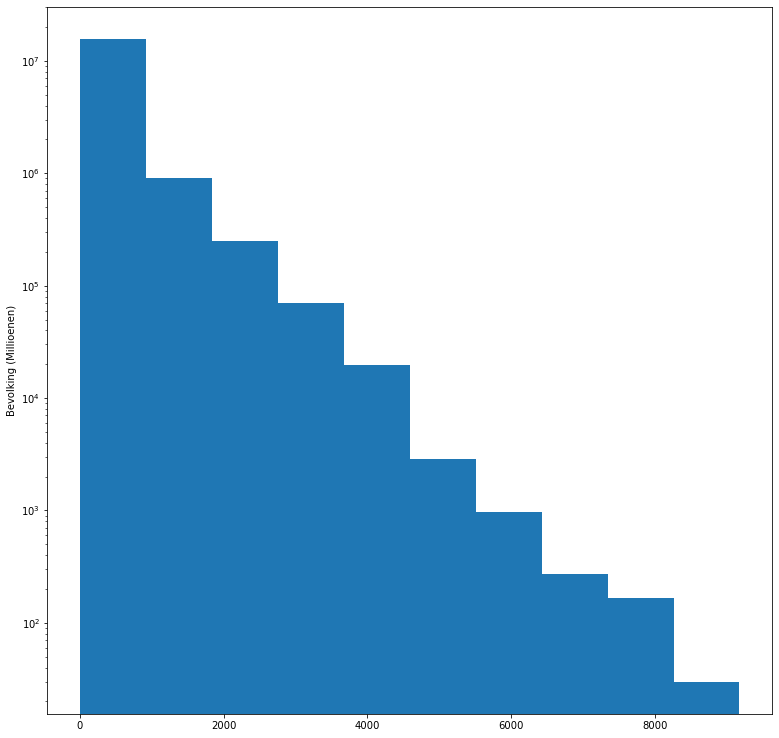

In [26]:
df_nearest['dist'].plot(kind="hist", weights=df_nearest['INWONER'], figsize=(13,13), density=False, log=True).set_ylabel('Bevolking (Millioenen)')

Het was mooier geweest als we het konden filteren op alleen stemgerechtigden en niet op de gehele populatiedichtheid, maar het CBS geeft geen data vrij die daarbij helpt. Er is een categorie voor 0-14 jaar oude mensen, maar niet alle minderjarigen of niet stemgerechtigde. Het moet dus maar met totale bevolkingsdichtheid om een idee te krijgen.

In [27]:
nl_map_dst_zero_points["INWONER"].mask(nl_map_dst_zero_points["INWONER"] == -99997, 0, inplace=True)
nl_map_dst_zero_points.head()
df_nearest_zero = ckdnearest(nl_map_dst_zero_points.to_crs(epsg=28992), gdf_wims_dedupe.to_crs(epsg=28992))
df_nearest_zero["INWONER"].dropna()
df_nearest_zero["dist"].dropna()
df_nearest_zero

,c28992r500,INWONER,geometry,savedindex,_id,Gemeente,CBS gemeentecode,Nummer stembureau,Naam stembureau,Gebruiksdoel van het gebouw,...,Gehandicaptentoilet,Kieskring ID,Hoofdstembureau,Tellocatie,Contactgegevens gemeente,Verkiezingswebsite gemeente,Verkiezingen,ID,UUID,dist
0,E2270N6190,0,POINT (227250.000 619250.000),2,31030,Het Hogeland,GM1966,1,Dorpshuis Pieterburen,"bijeenkomstfunctie,logiesfunctie",...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,17236.920436
1,E2275N6190,0,POINT (227750.000 619250.000),3,31030,Het Hogeland,GM1966,1,Dorpshuis Pieterburen,"bijeenkomstfunctie,logiesfunctie",...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,17280.014918
2,E2280N6190,0,POINT (228250.000 619250.000),4,31030,Het Hogeland,GM1966,1,Dorpshuis Pieterburen,"bijeenkomstfunctie,logiesfunctie",...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,17337.427867
3,E2265N6185,0,POINT (226750.000 618750.000),7,31030,Het Hogeland,GM1966,1,Dorpshuis Pieterburen,"bijeenkomstfunctie,logiesfunctie",...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,16708.725120
4,E2270N6185,0,POINT (227250.000 618750.000),8,31030,Het Hogeland,GM1966,1,Dorpshuis Pieterburen,"bijeenkomstfunctie,logiesfunctie",...,NaN,Het Hogeland,Het Hogeland,NaN,verkiezingen@hethogeland.nl,https://hethogeland.nl/bestuur-en-organisatie/...,NaN,NLODSGM1966stembureaus20220316009,6df04b8dd4be4aa3b4a03f221ab5ad17,16738.249149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139997,E1990N3070,0,POINT (199250.000 307250.000),151102,4103,Vaals,GM0981,3,Auw Sjoel,bijeenkomstfunctie,...,NaN,Vaals,Vaals,NaN,"Team verkiezingen, verkiezingen2022@vaals.nl",http://www.vaals.nl/verkiezingen,NaN,NLODSGM0981stembureaus20220316009,3dfcfccd163145698a33b19623c5c3f3,2010.126740
139998,E1995N3070,0,POINT (199750.000 307250.000),151103,4103,Vaals,GM0981,3,Auw Sjoel,bijeenkomstfunctie,...,NaN,Vaals,Vaals,NaN,"Team verkiezingen, verkiezingen2022@vaals.nl",http://www.vaals.nl/verkiezingen,NaN,NLODSGM0981stembureaus20220316009,3dfcfccd163145698a33b19623c5c3f3,1949.951758
139999,E1910N3065,0,POINT (191250.000 306750.000),151105,29739,Gulpen-Wittem,GM1729,7,Gemeenschapshuis Patronaat,woonfunctie,...,NaN,Gulpen-Wittem,Gulpen-Wittem,NaN,info@gulpen-wittem.nl 14 043,https://www.gulpen-wittem.nl/onderwerpen/verki...,NaN,NLODSGM1729stembureaus20220316009,feb9d0a67a2f460f906d0d21e87bf690,2880.233287
140000,E1920N3065,20,POINT (192250.000 306750.000),151106,29739,Gulpen-Wittem,GM1729,7,Gemeenschapshuis Patronaat,woonfunctie,...,NaN,Gulpen-Wittem,Gulpen-Wittem,NaN,info@gulpen-wittem.nl 14 043,https://www.gulpen-wittem.nl/onderwerpen/verki...,NaN,NLODSGM1729stembureaus20220316009,feb9d0a67a2f460f906d0d21e87bf690,2746.345509


In [28]:
df_nearest.sort_values(by=['dist'], inplace=True)
df_nearest[['Gemeente', 'Naam stembureau', 'dist']]

,Gemeente,Naam stembureau,dist
47198,Ridderkerk,Gemeentehuis,3.835321
32760,Baarn,Dorpshuis de Furs,4.000517
5146,Groningen,Dorpshuis De Hoeksteen,5.577246
38896,Montfoort,Zalencentrum St. Joseph,5.703409
67384,Kerkrade,’t Westhoes,7.252446
...,...,...,...
23387,Zeewolde,Het Kruispunt,8207.619943
22440,Lelystad,Gymzaal De Borg,8402.730770
22310,Lelystad,Voormalige Scholengemeenschap De Rietlanden,8540.805874
22439,Lelystad,Voormalige Scholengemeenschap De Rietlanden,9028.790070


<AxesSubplot:xlabel='Inwoners per 500m² (laagste is 5)', ylabel='Afstand tot stemlokaal (meter)'>

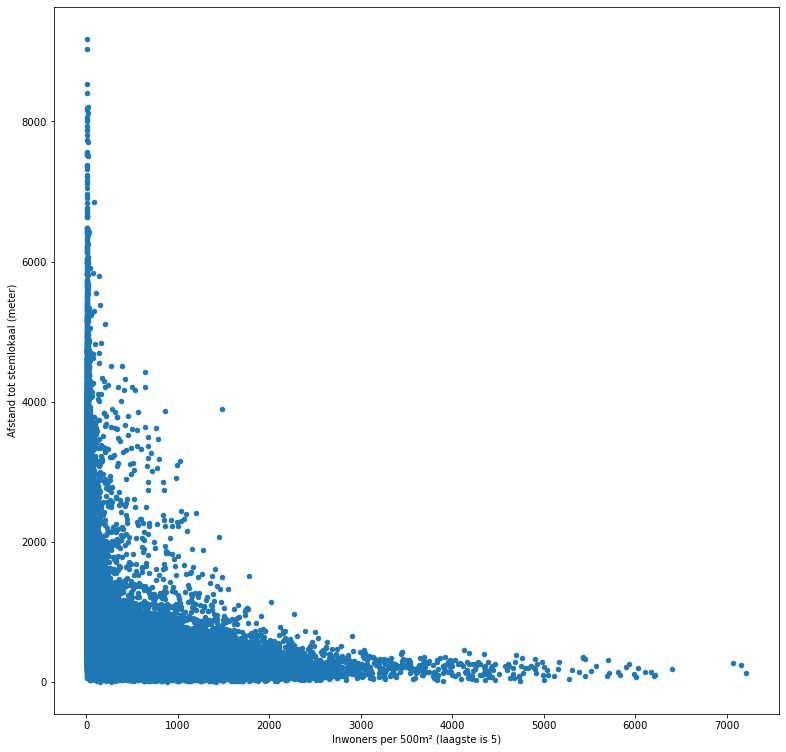

In [29]:
df_nearest.plot.scatter(x = 'INWONER', y = 'dist', figsize=(13,13), xlabel="Inwoners per 500m² (laagste is 5)", ylabel="Afstand tot stemlokaal (meter)")

<AxesSubplot:xlabel='Inwoners per 500m² (inclusief lege (<5 inwoners) vierkanten)', ylabel='Afstand tot stemlokaal (meter)'>

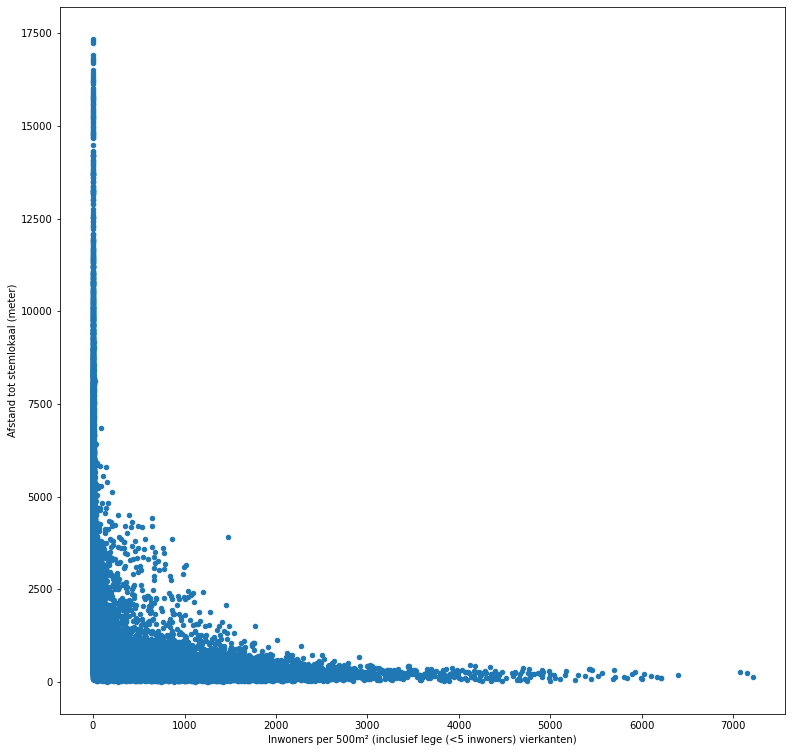

In [30]:
df_nearest_zero.plot.scatter(x = 'INWONER', y = 'dist', figsize=(13,13), xlabel="Inwoners per 500m² (inclusief lege (<5 inwoners) vierkanten)", ylabel="Afstand tot stemlokaal (meter)")

In [31]:
FIGSIZE = (13, 13)
def plot_bargraph_with_groupings(df, groupby, colourby, title, xlabel, ylabel):

    import matplotlib.patches as mpatches


    # Makes the bargraph.
    ax = df[groupby].value_counts().plot(kind='bar',
                                         figsize=FIGSIZE,
                                         title=title)
    

    # display the graph.
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

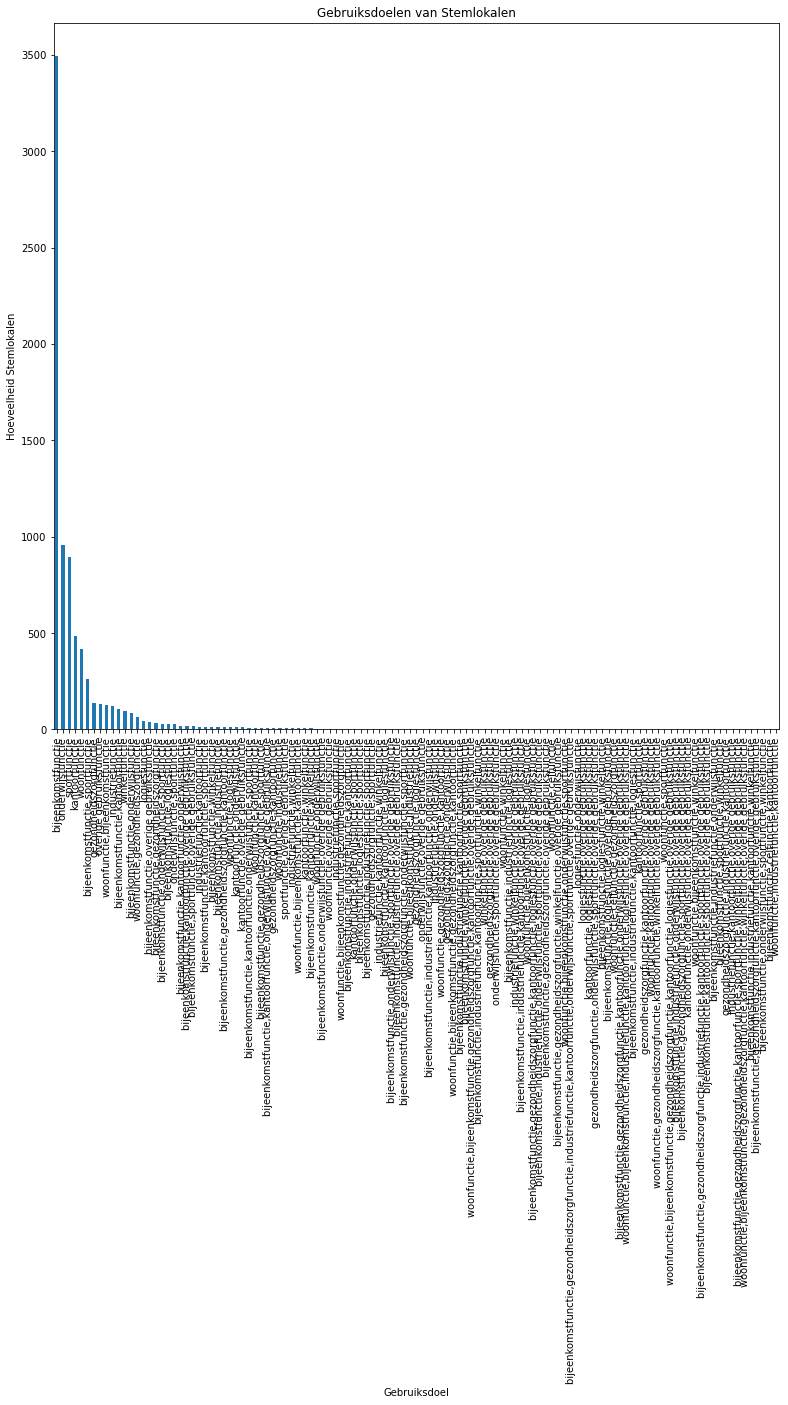

In [32]:
plot_bargraph_with_groupings(gdf_wims_dedupe, 'Gebruiksdoel van het gebouw', 'Gemeente', 'Gebruiksdoelen van Stemlokalen', 'Gebruiksdoel', 'Hoeveelheid Stemlokalen')

Dit is onbruikbaar, de categorieën moeten elk één balkje zijn, niet zoals dit.

In [33]:
gdf_wims_exploded = gdf_wims_dedupe.drop('Gebruiksdoel van het gebouw', axis=1).join(
  gdf_wims_dedupe['Gebruiksdoel van het gebouw'].str.split(',', expand=True).stack().reset_index(level=1,drop=True).rename('Gebruiksdoel van het gebouw'))

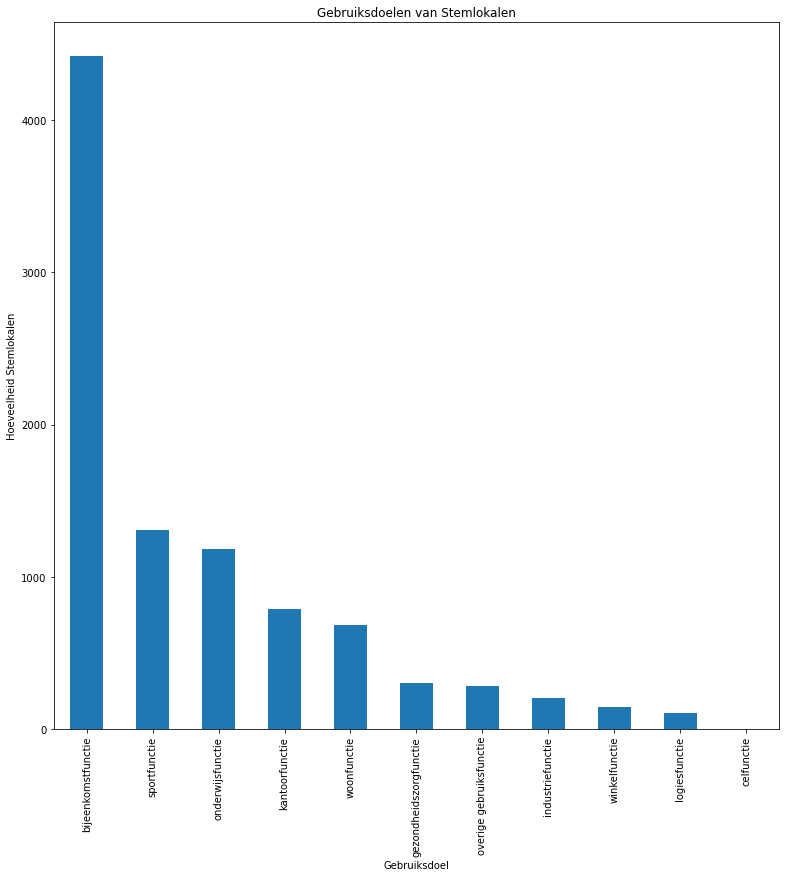

In [34]:
plot_bargraph_with_groupings(gdf_wims_exploded, 'Gebruiksdoel van het gebouw', 'Gemeente', 'Gebruiksdoelen van Stemlokalen', 'Gebruiksdoel', 'Hoeveelheid Stemlokalen')

In [35]:

wims_count = gdf_wims_dedupe['Gemeente'].value_counts()


geojson_rename = df_geojson_dedupe.rename(columns = {'electionName': 'Gemeente'})
geojson_count = geojson_rename['Gemeente'].str.slice(13, -5).value_counts()

pd.concat([geojson_count, wims_count]).drop_duplicates(keep=False)


Amsterdam              456
Rotterdam              398
's-Gravenhage          271
Utrecht                162
Breda                   90
Eindhoven               86
Groningen               85
Apeldoorn               71
Enschede                69
Alphen aan den Rijn     66
Leiden                  52
Deventer                51
West Betuwe             37
Waadhoeke               33
Amsterdam              382
Rotterdam              375
's-Gravenhage          258
Utrecht                161
Groningen              122
Breda                   89
Haarlemmermeer          79
Nijmegen                74
's-Hertogenbosch        40
Het Hogeland            39
Zoetermeer              38
Staphorst                2
Name: Gemeente, dtype: int64

In [36]:
gdf_wims_times = gdf_wims_dedupe.loc[:, ('Openingstijden 14-03-2022','Openingstijden 15-03-2022','Openingstijden 16-03-2022', 'UUID', 'Gemeente', 'CBS gemeentecode')]
gdf_wims_split = gdf_wims_times
gdf_wims_split[['Openingstijden 14-03-2022 van', 'Openingstijden 14-03-2022 tot']] = gdf_wims_times['Openingstijden 14-03-2022'].str.split(' tot ',1 , expand=True)
gdf_wims_split[['Openingstijden 15-03-2022 van', 'Openingstijden 15-03-2022 tot']] = gdf_wims_split['Openingstijden 15-03-2022'].str.split(' tot ',1 , expand=True)
gdf_wims_split[['Openingstijden 16-03-2022 van', 'Openingstijden 16-03-2022 tot']] = gdf_wims_split['Openingstijden 16-03-2022'].str.split(' tot ',1 , expand=True)

gdf_wims_split

,Openingstijden 14-03-2022,Openingstijden 15-03-2022,Openingstijden 16-03-2022,UUID,Gemeente,CBS gemeentecode,Openingstijden 14-03-2022 van,Openingstijden 14-03-2022 tot,Openingstijden 15-03-2022 van,Openingstijden 15-03-2022 tot,Openingstijden 16-03-2022 van,Openingstijden 16-03-2022 tot
0,NaN,NaN,2022-03-16T10:00:00 tot 2022-03-16T13:00:00,3a612b2151fa4ab491b9e331355e6258,Valkenswaard,GM0858,NaN,NaN,NaN,NaN,2022-03-16T10:00:00,2022-03-16T13:00:00
1,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,9a01d765af0a467ea37f08d92db114ba,Valkenswaard,GM0858,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00
2,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,fc5869d33fbc4b06be659149fa615f4c,Valkenswaard,GM0858,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00
3,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,4427cc0b39e040ba8f75c333f19d66f0,Valkenswaard,GM0858,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00
4,2022-03-14T07:30:00 tot 2022-03-14T21:00:00,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,a893bb9add324ce29769f1c39afcc48d,Valkenswaard,GM0858,2022-03-14T07:30:00,2022-03-14T21:00:00,2022-03-15T07:30:00,2022-03-15T21:00:00,2022-03-16T07:30:00,2022-03-16T21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
9270,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,f744546cd6894e5e9a4db4bbfd81b4ee,Gennep,GM0907,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00
9271,2022-03-14T07:30:00 tot 2022-03-14T21:00:00,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,1270081b1dc74cd7bea0f45973650408,Gennep,GM0907,2022-03-14T07:30:00,2022-03-14T21:00:00,2022-03-15T07:30:00,2022-03-15T21:00:00,2022-03-16T07:30:00,2022-03-16T21:00:00
9272,NaN,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,447c7742604345139e41def4cf1e4d3c,Gennep,GM0907,NaN,NaN,2022-03-15T07:30:00,2022-03-15T21:00:00,2022-03-16T07:30:00,2022-03-16T21:00:00
9273,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,049cfd258c174bc49abf17883396d083,Gennep,GM0907,NaN,NaN,NaN,NaN,2022-03-16T07:30:00,2022-03-16T21:00:00


In [37]:
gdf_wims_split[['Openingstijden 14-03-2022 van','Openingstijden 15-03-2022 van','Openingstijden 16-03-2022 van', 'Openingstijden 14-03-2022 tot', 'Openingstijden 15-03-2022 tot','Openingstijden 16-03-2022 tot']] = gdf_wims_split[['Openingstijden 14-03-2022 van','Openingstijden 15-03-2022 van','Openingstijden 16-03-2022 van','Openingstijden 14-03-2022 tot','Openingstijden 15-03-2022 tot','Openingstijden 16-03-2022 tot']].apply(pd.to_datetime, errors='coerce')
gdf_wims_split

,Openingstijden 14-03-2022,Openingstijden 15-03-2022,Openingstijden 16-03-2022,UUID,Gemeente,CBS gemeentecode,Openingstijden 14-03-2022 van,Openingstijden 14-03-2022 tot,Openingstijden 15-03-2022 van,Openingstijden 15-03-2022 tot,Openingstijden 16-03-2022 van,Openingstijden 16-03-2022 tot
0,NaN,NaN,2022-03-16T10:00:00 tot 2022-03-16T13:00:00,3a612b2151fa4ab491b9e331355e6258,Valkenswaard,GM0858,NaT,NaT,NaT,NaT,2022-03-16 10:00:00,2022-03-16 13:00:00
1,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,9a01d765af0a467ea37f08d92db114ba,Valkenswaard,GM0858,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00
2,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,fc5869d33fbc4b06be659149fa615f4c,Valkenswaard,GM0858,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00
3,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,4427cc0b39e040ba8f75c333f19d66f0,Valkenswaard,GM0858,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00
4,2022-03-14T07:30:00 tot 2022-03-14T21:00:00,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,a893bb9add324ce29769f1c39afcc48d,Valkenswaard,GM0858,2022-03-14 07:30:00,2022-03-14 21:00:00,2022-03-15 07:30:00,2022-03-15 21:00:00,2022-03-16 07:30:00,2022-03-16 21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
9270,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,f744546cd6894e5e9a4db4bbfd81b4ee,Gennep,GM0907,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00
9271,2022-03-14T07:30:00 tot 2022-03-14T21:00:00,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,1270081b1dc74cd7bea0f45973650408,Gennep,GM0907,2022-03-14 07:30:00,2022-03-14 21:00:00,2022-03-15 07:30:00,2022-03-15 21:00:00,2022-03-16 07:30:00,2022-03-16 21:00:00
9272,NaN,2022-03-15T07:30:00 tot 2022-03-15T21:00:00,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,447c7742604345139e41def4cf1e4d3c,Gennep,GM0907,NaT,NaT,2022-03-15 07:30:00,2022-03-15 21:00:00,2022-03-16 07:30:00,2022-03-16 21:00:00
9273,NaN,NaN,2022-03-16T07:30:00 tot 2022-03-16T21:00:00,049cfd258c174bc49abf17883396d083,Gennep,GM0907,NaT,NaT,NaT,NaT,2022-03-16 07:30:00,2022-03-16 21:00:00


In [46]:
wims_datemerge = pd.DataFrame()
def datesplit(df, column):
    df = df.dropna(subset = ['{} van'.format(column)])
    df1 = df.rename(columns={'{} van'.format(column):'vandate','{} tot'.format(column):'totdate', 'UUID':'UUID'})
    return  (pd.concat([pd.Series(r.UUID,pd.date_range(r.vandate, r.totdate, freq='0.5H')) 
                        for r in df1.itertuples()])
               .rename_axis('Openingstijden')
               .reset_index(name='UUID'))
def plot_opening(df, label):
    plt.figure(figsize=(13,13))
    wims_datesplit_14 = df.loc[:, ('Openingstijden 14-03-2022 van','Openingstijden 14-03-2022 tot', 'UUID')]
    wims_datesplit_15 = df.loc[:, ('Openingstijden 15-03-2022 van','Openingstijden 15-03-2022 tot', 'UUID')]
    wims_datesplit_16 = df.loc[:, ('Openingstijden 16-03-2022 van','Openingstijden 16-03-2022 tot', 'UUID')]
    wims_datesplit_14 = datesplit(wims_datesplit_14, 'Openingstijden 14-03-2022')
    wims_datesplit_15 = datesplit(wims_datesplit_15, 'Openingstijden 15-03-2022')
    wims_datesplit_16 = datesplit(wims_datesplit_16, 'Openingstijden 16-03-2022')

    wims_datesplit_14.reset_index()
    wims_datesplit_15.reset_index()
    wims_datesplit_16.reset_index()

    #wims_datesplit_14.info()
    #wims_datesplit_15.info()
    #wims_datesplit_16.info()

    
    wims_datestack = pd.concat([wims_datesplit_14, wims_datesplit_15], ignore_index=True)
    wims_datestack = pd.concat([wims_datestack, wims_datesplit_16], ignore_index=True)
    

    

    wims_datestack.set_index('Openingstijden', drop=False, inplace=True)

    #print(wims_datestack['Openingstijden'].unique())

    xticks = []
    xticklabels = []
    datetimecount = 0
    for datetime in wims_datestack['Openingstijden'].unique():
        print(datetime)
        xticks.append(datetime)
        if(datetimecount % 6 == 0):
            xticklabels.append(datetime)
        else:
            xticklabels.append("")
        datetimecount += 1


    wims_datestack.groupby(pd.Grouper(freq='30Min')).count().plot(kind='bar', y='Openingstijden',width=1, figsize=(25, 25), title="Openingstijden stemlokalen staffel {} kiesgerechtigden".format(label))

    #wims_datesplit_16.groupby(wims_datesplit_16["Openingstijden 16-03-2022"].dt.hour).count().plot(kind="bar", y='Openingstijden 16-03-2022')
    #wims_datesplit_16.groupby(pd.Grouper(freq='30Min')).count().plot(kind='bar', y='Openingstijden 16-03-2022')
    #wims_datesplit_15.groupby(wims_datesplit_15["Openingstijden 15-03-2022"].dt.hour).count().plot(kind="bar", y='Openingstijden 15-03-2022')
    #wims_datesplit_14.groupby(wims_datesplit_14["Openingstijden 14-03-2022"].dt.hour).count().plot(kind="bar", y='Openingstijden 14-03-2022')


In [39]:
df_stemger = pd.read_excel('../data/Maatwerk_kiesgerechtigd_per_gemeente_def.xlsx', sheet_name='Tabel 1', header=0, skiprows= [0,1,3,5,6,7,344,345])
df_stemger_clean = df_stemger[df_stemger['gemeentecode'].isin(nl_map_clean['GM_CODE'])]

bins = [0, 1, 3, 6, 10, 35, float("inf")]
labels = ['0-10.000', '10.000-30.000', '30.000-60.000', '60.000-100.000', '100.000-350.000', '350.000+']

df_stemger_clean['binned'] = pd.cut(df_stemger_clean['Kiesgerechtigde bevolking'], bins, labels=labels)


/tmp/ipykernel_7786/2535562662.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stemger_clean['binned'] = pd.cut(df_stemger_clean['Kiesgerechtigde bevolking'], bins, labels=labels)


2022-03-14T07:30:00.000000000
2022-03-14T08:00:00.000000000
2022-03-14T08:30:00.000000000
2022-03-14T09:00:00.000000000
2022-03-14T09:30:00.000000000
2022-03-14T10:00:00.000000000
2022-03-14T10:30:00.000000000
2022-03-14T11:00:00.000000000
2022-03-14T11:30:00.000000000
2022-03-14T12:00:00.000000000
2022-03-14T12:30:00.000000000
2022-03-14T13:00:00.000000000
2022-03-14T13:30:00.000000000
2022-03-14T14:00:00.000000000
2022-03-14T14:30:00.000000000
2022-03-14T15:00:00.000000000
2022-03-14T15:30:00.000000000
2022-03-14T16:00:00.000000000
2022-03-14T16:30:00.000000000
2022-03-14T17:00:00.000000000
2022-03-14T17:30:00.000000000
2022-03-14T18:00:00.000000000
2022-03-14T18:30:00.000000000
2022-03-14T19:00:00.000000000
2022-03-14T19:30:00.000000000
2022-03-14T20:00:00.000000000
2022-03-14T20:30:00.000000000
2022-03-14T21:00:00.000000000
2022-03-15T07:30:00.000000000
2022-03-15T08:00:00.000000000
2022-03-15T08:30:00.000000000
2022-03-15T09:00:00.000000000
2022-03-15T09:30:00.000000000
2022-03-15

<Figure size 936x936 with 0 Axes>

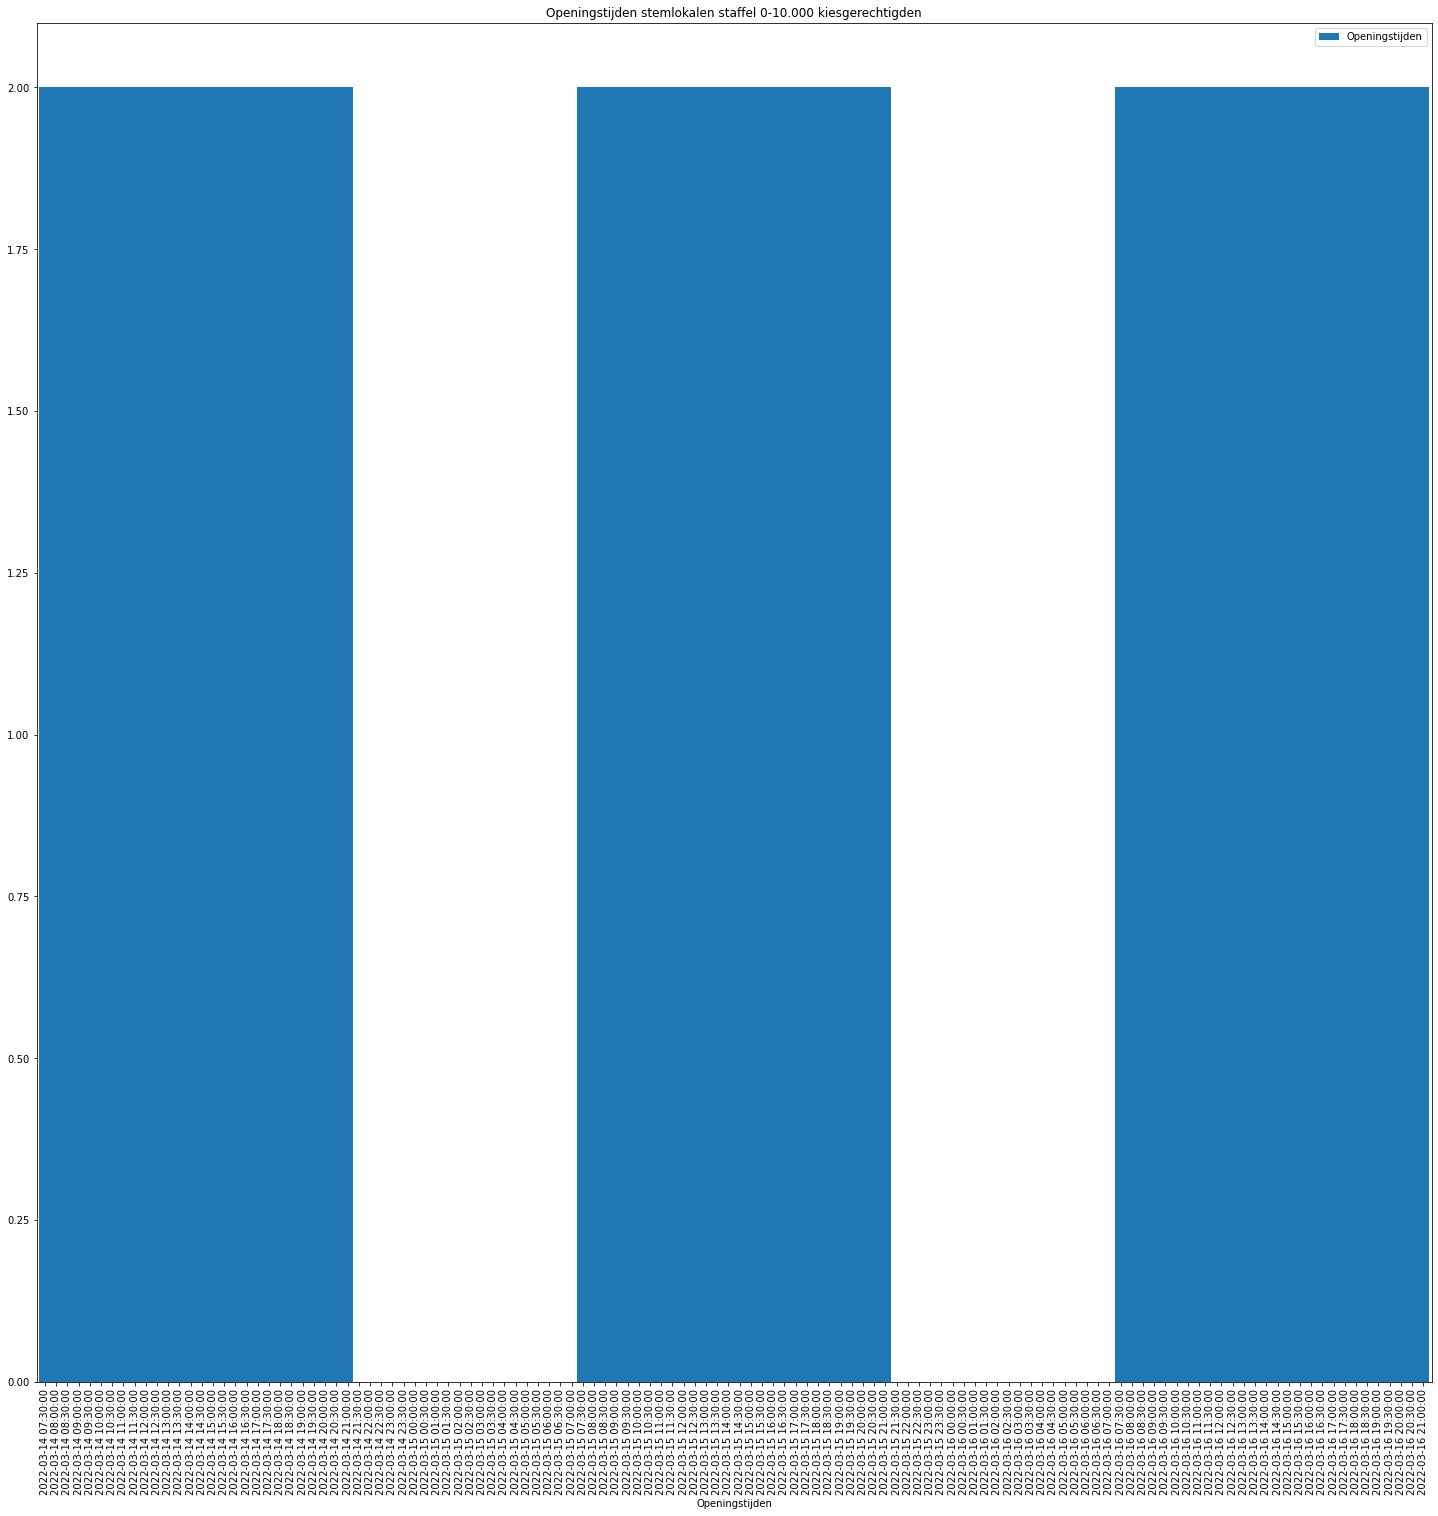

<Figure size 936x936 with 0 Axes>

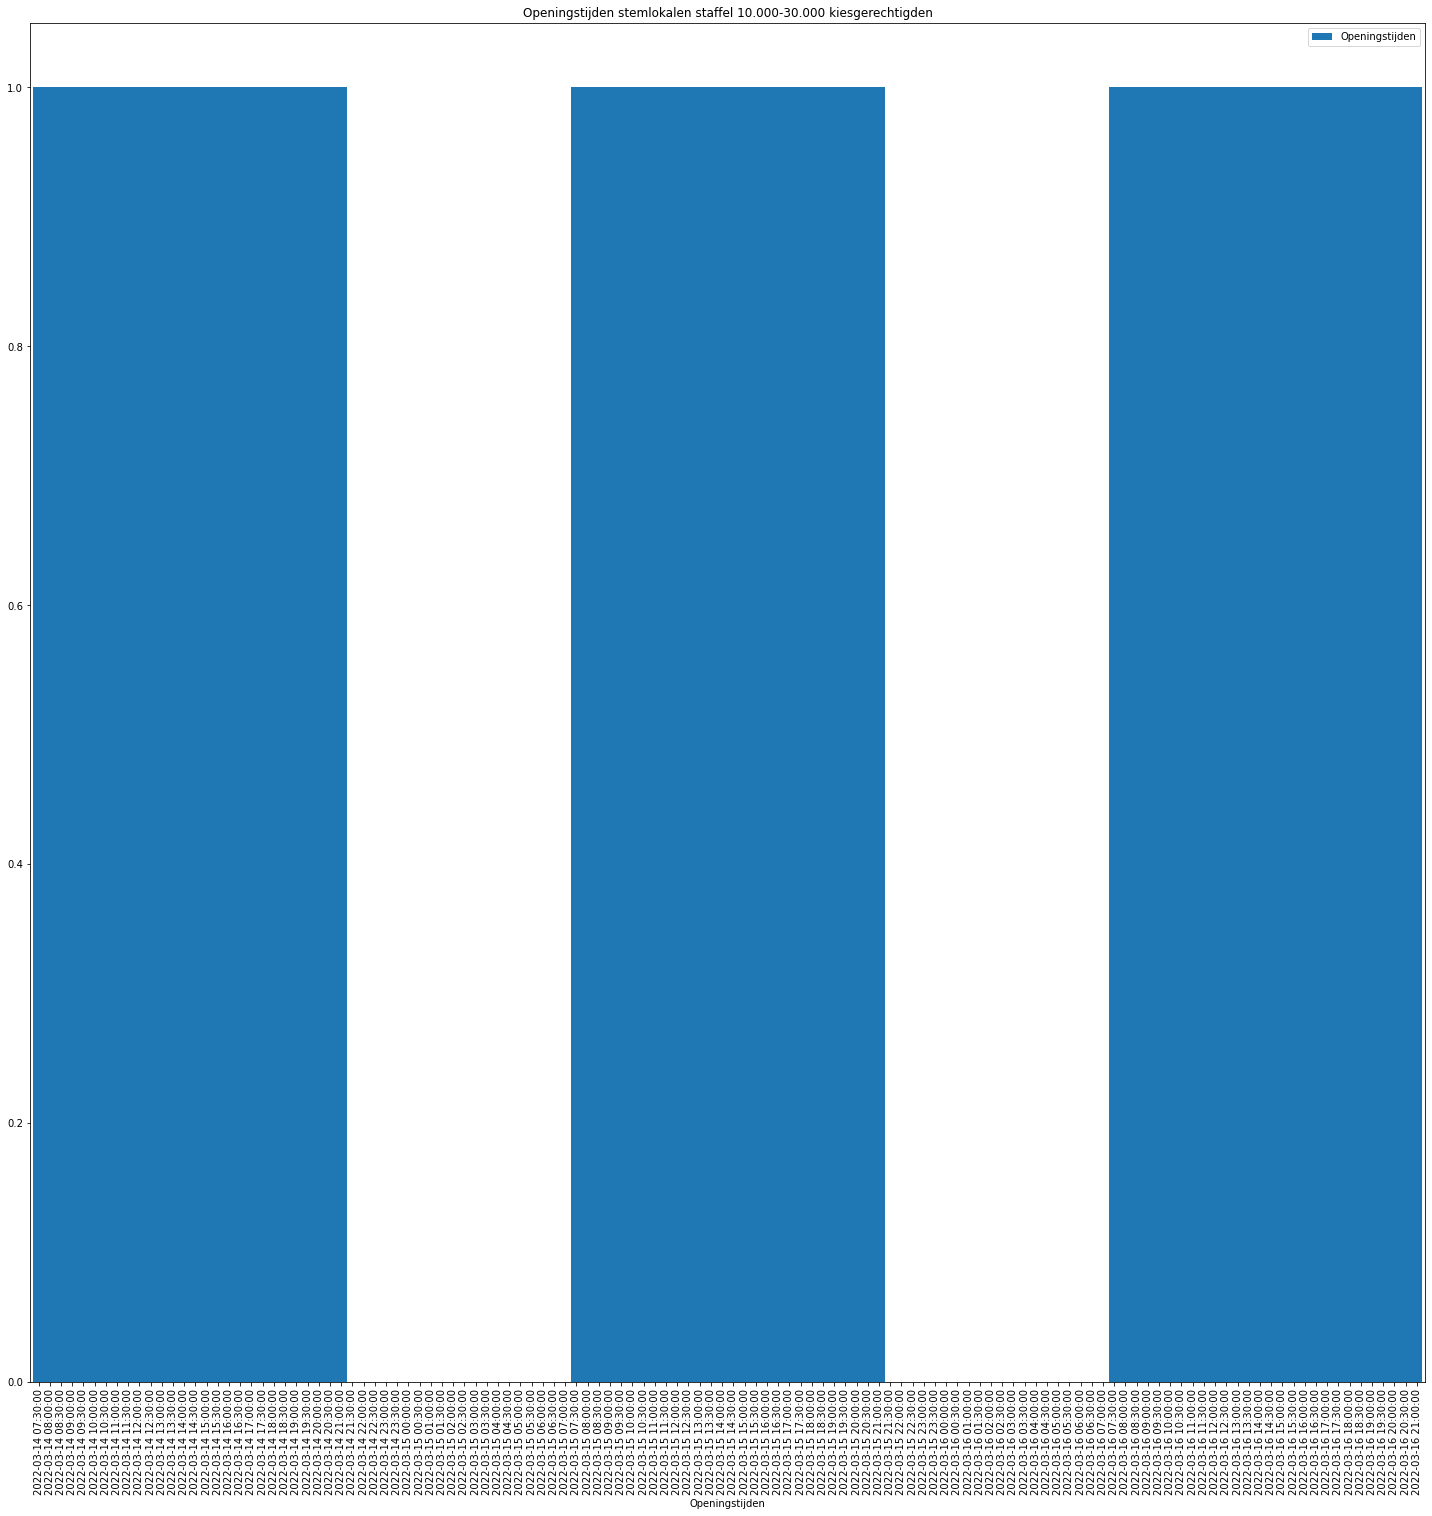

<Figure size 936x936 with 0 Axes>

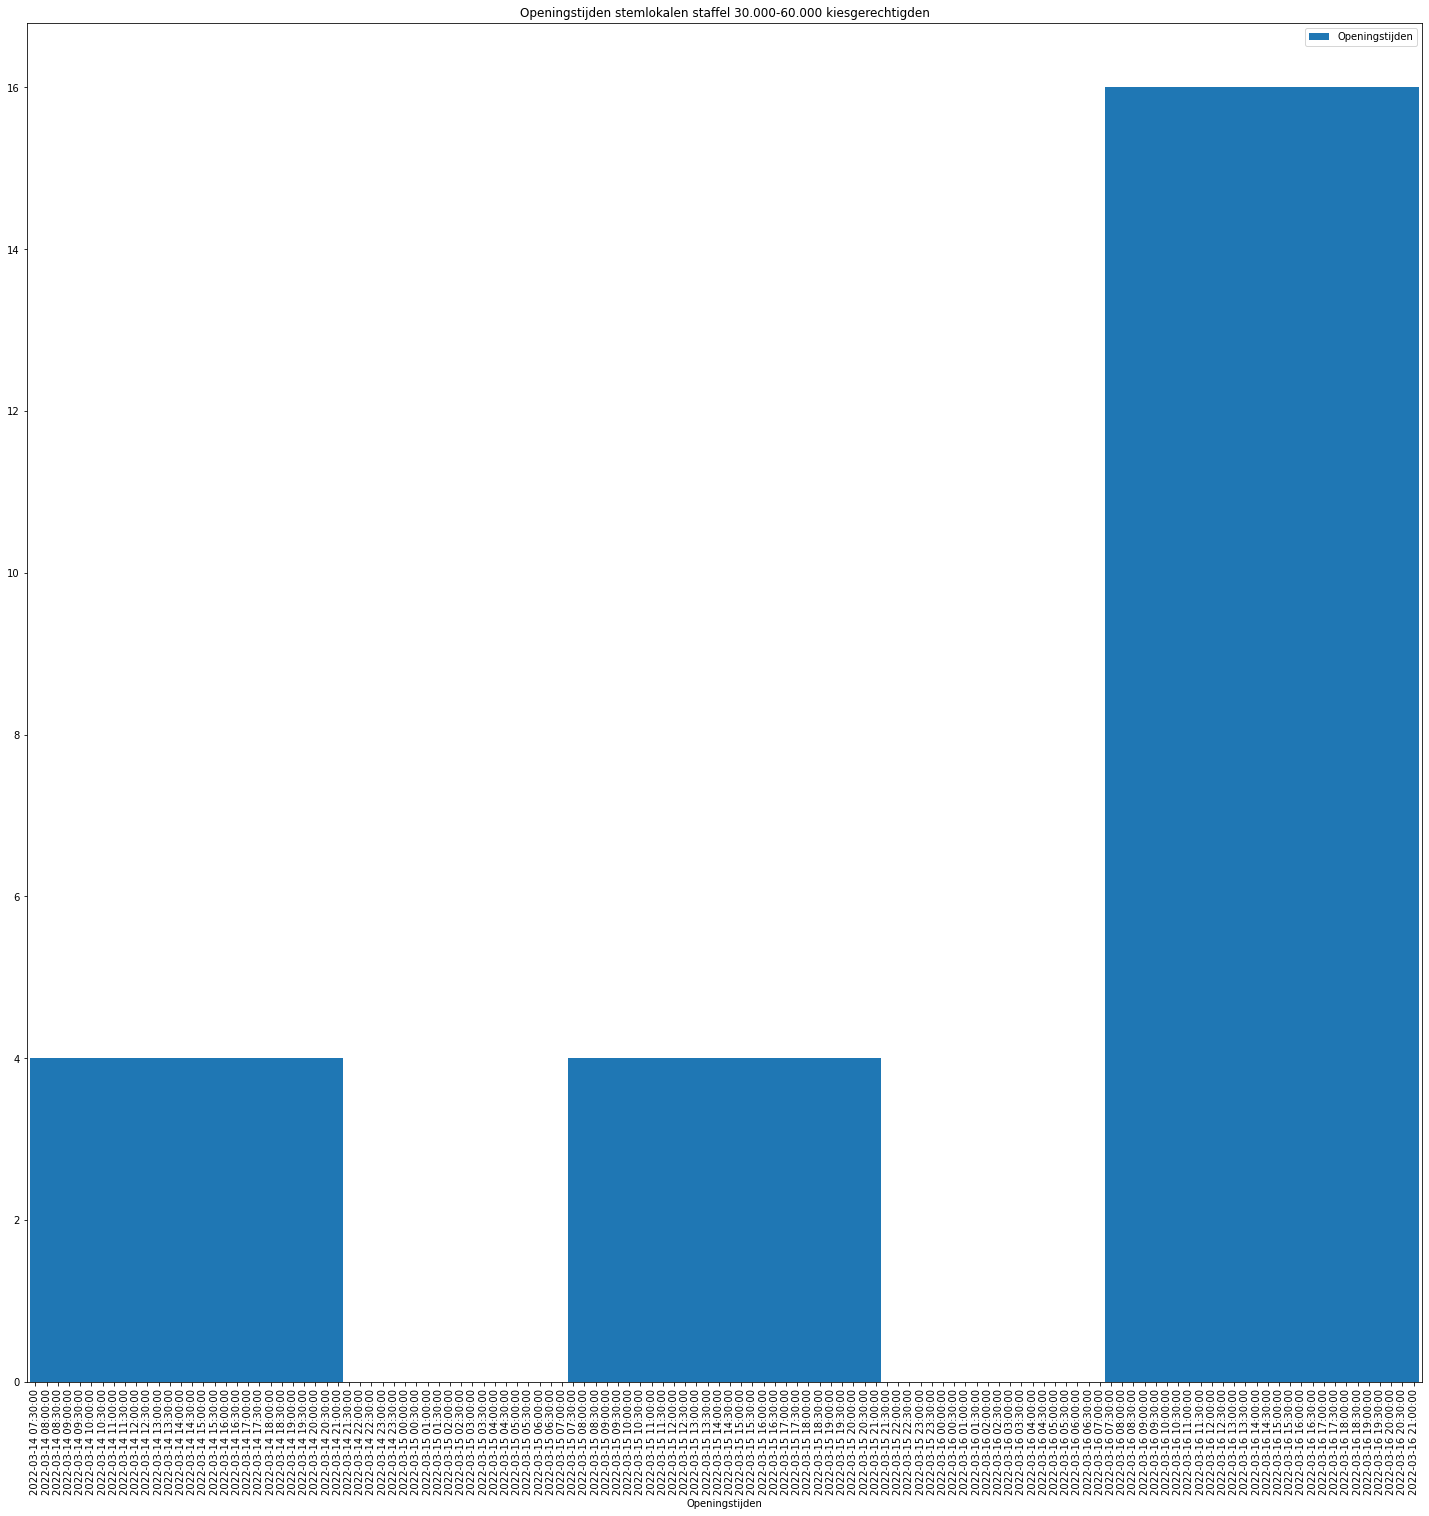

<Figure size 936x936 with 0 Axes>

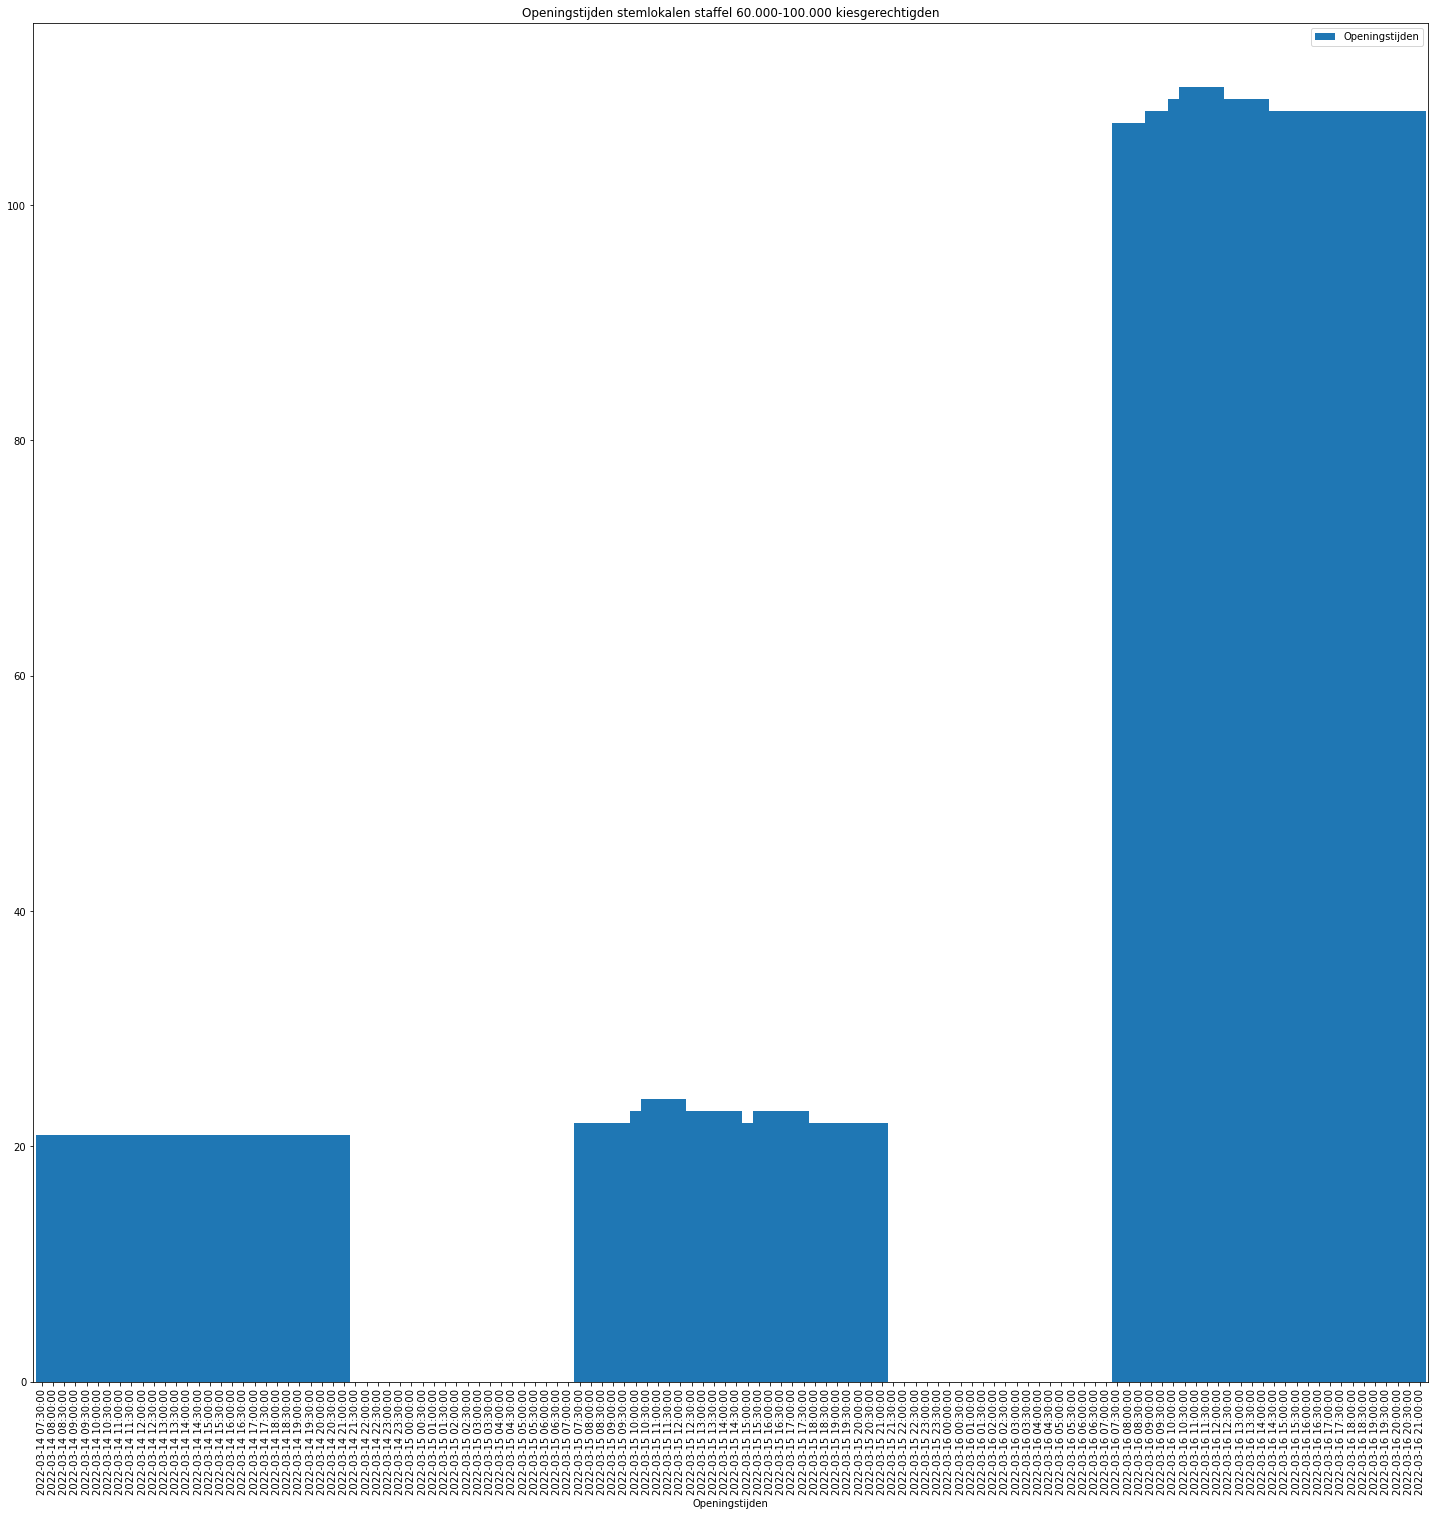

<Figure size 936x936 with 0 Axes>

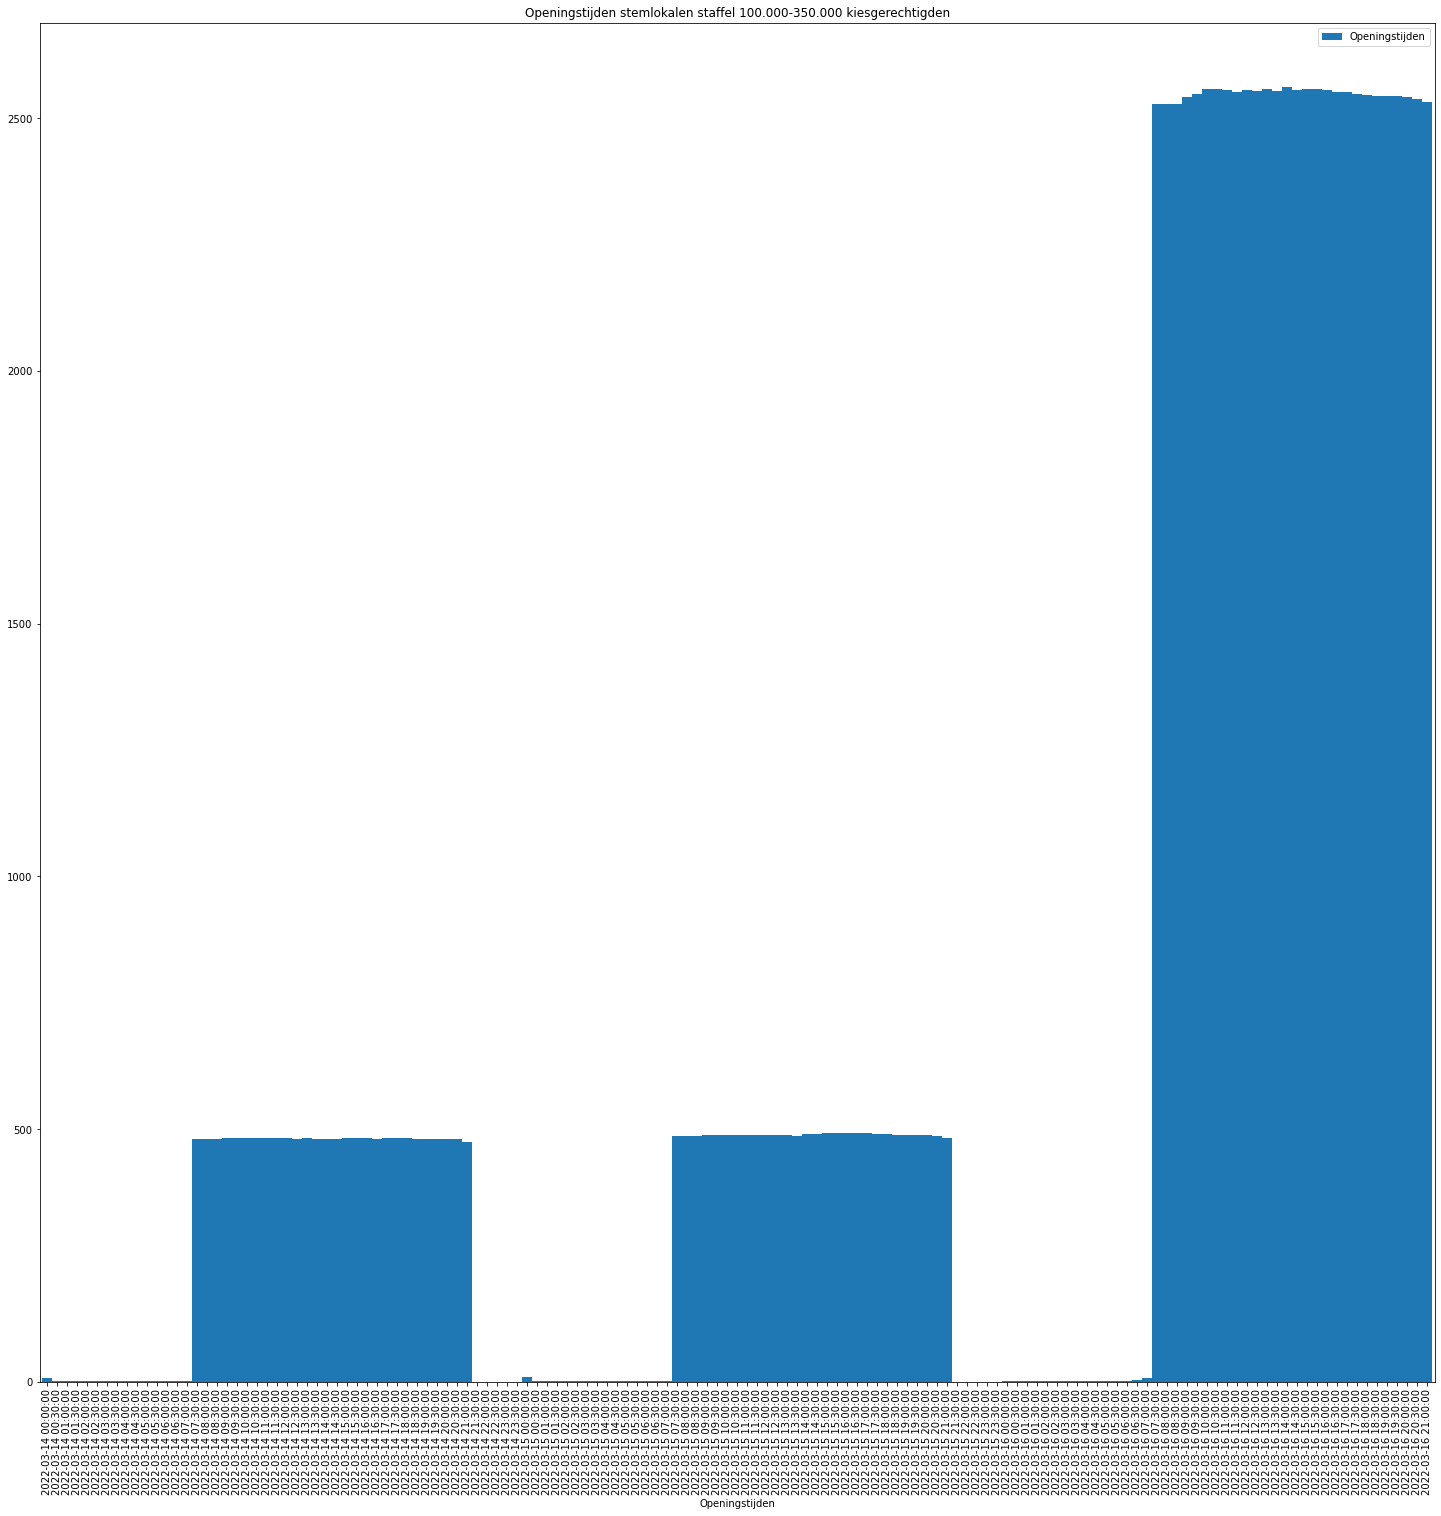

<Figure size 936x936 with 0 Axes>

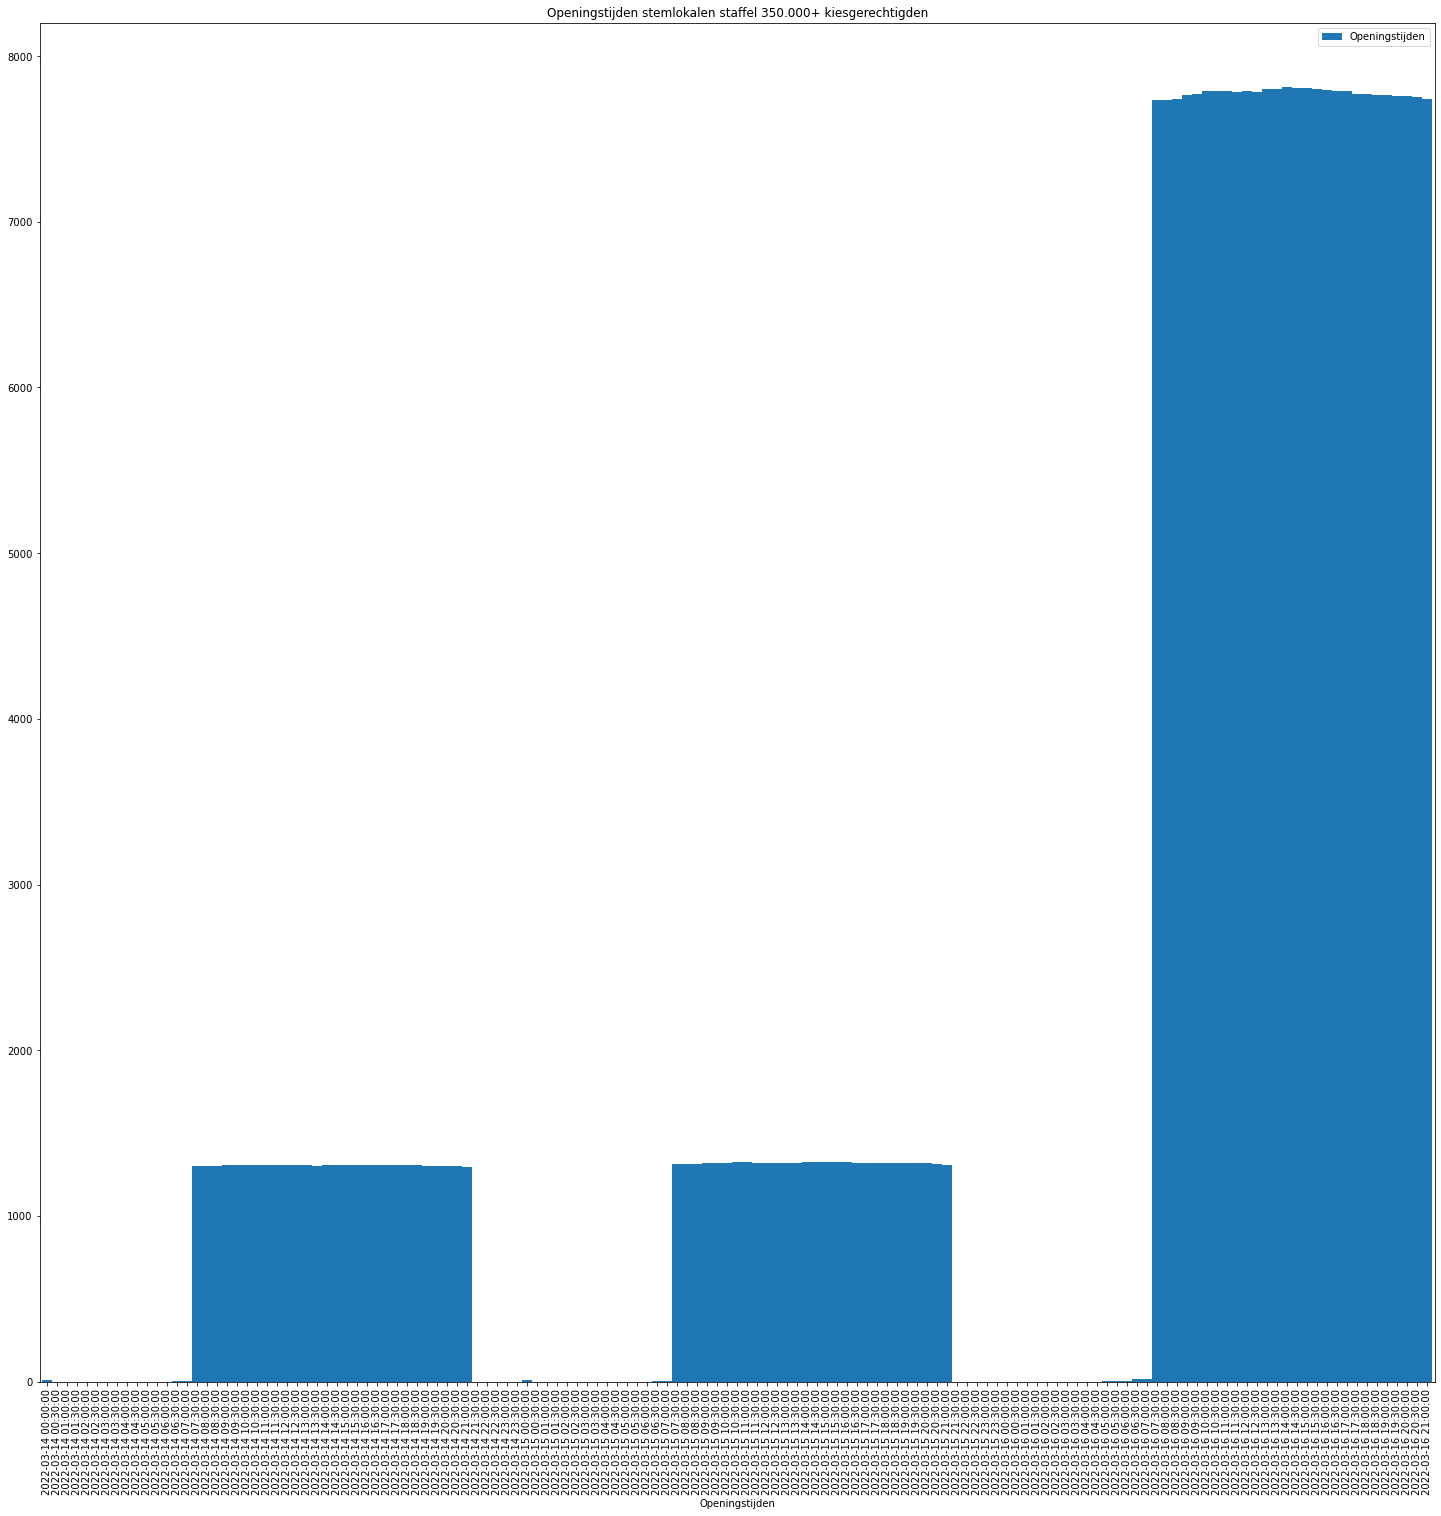

In [47]:
def filter_binned(df_wims, df_stemger):
    return df_wims[df_wims['CBS gemeentecode'].isin(df_stemger['gemeentecode'])]

def make_graphs(label):
    df_stemger_label = df_stemger_clean[df_stemger_clean['binned'].str.contains(label)]
    df_stemger_label.head()
    graph_wims = filter_binned(gdf_wims_dedupe, df_stemger_label)
    graph_wims_split = filter_binned(gdf_wims_split, df_stemger_label)
    plot_opening(graph_wims_split, label)
    
for label in labels:
    make_graphs(label)

In [41]:
#de eerste vijf rijen zijn meta-data en kunnen we gerust weghalen voor nu 
df_gr_gr = pd.read_csv(r'../data/stemmen/01_Groningen/osv4-3_telling_gr2022_groningen.csv', skiprows=5, header=None, delimiter=';')
print(df_gr_gr)

              0                    1           2                3       4    \
0     Lijstnummer           Aanduiding  Volgnummer   Naam kandidaat  Totaal   
1    Gebiednummer                  NaN         NaN              NaN     NaN   
2        Postcode                  NaN         NaN              NaN     NaN   
3             NaN         opgeroepenen         NaN              NaN  194113   
4             NaN      geldige stempas         NaN              NaN   96830   
..            ...                  ...         ...              ...     ...   
445           NaN                  NaN           5     Oetomo, A.D.      38   
446           NaN                  NaN           6         Smid, D.      25   
447           NaN                  NaN           7  van Welij, P.Z.      10   
448            16  Blanco (Dokter, T.)         NaN              NaN     100   
449           NaN                  NaN           1       Dokter, T.     100   

                                5    \
0    GRID Gr

De data is heel gecompliceerd, dus we moeten het bruikbaar maken in pandas. Met hoe de data eruit ziet in een CSV in libre office willen we een constructie maken van de verschillende onderdelen. We hebben de data van de stemlokalen apart al, die kunnen we dus negeren. We willen de data van de lijsten apart hebben. 

In [42]:

#TODO:mobiele stemlokalen eruit filteren die NIET 0,0 zijn
#TODO:datastandaard duitse verkiezingen stemlokaalafstand opzoeken